<a href="https://colab.research.google.com/github/PrswpkWirom/DepressionFinal/blob/main/MFFNet/DD_dataloader%2BVanillaMFFNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydub

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import random
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import numpy as np
import wave
#from pydub import AudioSegment
from io import BytesIO
from IPython.display import Audio, display
from transformers import RobertaTokenizer, RobertaModel, Wav2Vec2FeatureExtractor
from transformers.models.wavlm import WavLMModel

In [3]:
database_dir = '/content/drive/MyDrive/DAIC_WOZ'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("microsoft/wavlm-large")
wavlm_model = WavLMModel.from_pretrained("microsoft/wavlm-large").to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.22k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

In [ ]:
from transformers import AutoTokenizer, AutoModel
model_name = "roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
text_model = AutoModel.from_pretrained(model_name)
text_model = text_model.to(device)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Attempt 1

In [ ]:
def get_sentence_level_text_embedding(sentence, tokenizer, text_model):
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = text_model(**inputs)
    sentence_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token embedding
    return sentence_embedding.squeeze(0)

def get_audio_embedding(audio_segment, feature_extractor, wavlm_model):
    audio_data = np.array(audio_segment.get_array_of_samples()).astype(np.int16)
    audio_data_tensor = torch.tensor(audio_data, dtype=torch.float32).to(device)

    inputs = feature_extractor(
        audio_data_tensor,
        sampling_rate=audio_segment.frame_rate,
        return_tensors="pt",
        padding=True
    )
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = wavlm_model(**inputs)

    # last_hidden_state: (1, time_steps, embedding_dim)
    audio_embeddings = outputs.last_hidden_state.squeeze(0)
    # Average pooling over time
    audio_embedding_vector = audio_embeddings.mean(dim=0)
    return audio_embedding_vector


In [ ]:
def load_label_dict(label_csv_path):
    """
    Loads a CSV file that contains columns: "ID" and "PHQ8_Binary".
    Returns a dictionary mapping the string ID (e.g., "315") to the binary label (0 or 1).
    """
    df = pd.read_csv(label_csv_path)
    label_dict = {}
    for _, row in df.iterrows():
        base_id = str(row["Participant_ID"])  # Ensure it's a string for indexing
        label = int(row["PHQ8_Binary"])
        label_dict[base_id] = label
    return label_dict

In [ ]:
class DAICDataset(Dataset):
    def __init__(self, root_dir, label_csv_path, tokenizer, text_model, feature_extractor, wavlm_model, device, embeddings_dir='embeddings'):
        self.root_dir = root_dir
        self.tokenizer = tokenizer
        self.text_model = text_model
        self.feature_extractor = feature_extractor
        self.wavlm_model = wavlm_model
        self.device = device
        self.embeddings_dir = embeddings_dir

        # Load labels as before
        self.label_dict = load_label_dict(label_csv_path)

        self.session_ids = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.data = []
        self._prepare_data()

    def _prepare_data(self):
        # Ensure the embeddings directory for this split exists
        if not os.path.exists(self.embeddings_dir):
            os.makedirs(self.embeddings_dir)

        split_name = os.path.basename(self.root_dir)  # e.g., 'train', 'validate', 'test'
        split_embeddings_dir = os.path.join(self.embeddings_dir, split_name)
        if not os.path.exists(split_embeddings_dir):
            os.makedirs(split_embeddings_dir)

        for session_id in self.session_ids:
            base_id = session_id.split('_')[0]
            session_path = os.path.join(self.root_dir, session_id)
            embed_file_path = os.path.join(split_embeddings_dir, f"{session_id}.pt")

            if os.path.exists(embed_file_path):
                # Load precomputed embeddings
                saved_data = torch.load(embed_file_path)
                text_sequence = saved_data['text_sequence']
                audio_sequence = saved_data['audio_sequence']
                label = saved_data['label']
                self.data.append((text_sequence, audio_sequence, label))
                continue

            # If embeddings file doesn't exist, proceed with computation
            transcript_file, audio_file = self._find_files(session_path)
            if transcript_file is None or audio_file is None:
                print(f"Missing transcript or audio for {session_id}, skipping.")
                continue

            filtered_df = self._load_and_filter_transcript(transcript_file)
            if filtered_df is None:
                continue

            if not os.path.exists(audio_file):
                print(f"Audio file not found: {audio_file}")
                continue
            full_audio = AudioSegment.from_wav(audio_file)

            aligned_data = []
            for _, row in filtered_df.iterrows():
                try:
                    start_time = float(row["start_time"])
                    stop_time = float(row["stop_time"])
                    sentence = row["value"]
                    start_ms = int(start_time * 1000)
                    stop_ms = int(stop_time * 1000)
                    audio_segment = full_audio[start_ms:stop_ms]

                    aligned_data.append({
                        "start_time": start_time,
                        "stop_time": stop_time,
                        "sentence": sentence,
                        "audio_segment": audio_segment
                    })
                except ValueError:
                    continue

            if len(aligned_data) == 0:
                continue

            # Compute embeddings
            text_embeddings = []
            audio_embeddings = []
            for entry in aligned_data:
                text_emb = get_sentence_level_text_embedding(entry["sentence"], self.tokenizer, self.text_model)
                audio_emb = get_audio_embedding(entry["audio_segment"], self.feature_extractor, self.wavlm_model)
                text_embeddings.append(text_emb)
                audio_embeddings.append(audio_emb)
                #print(f"Succesfully generate embedding of {entry}")

            if len(text_embeddings) == 0:
                continue

            text_sequence = torch.stack(text_embeddings, dim=0)
            audio_sequence = torch.stack(audio_embeddings, dim=0)

            if base_id not in self.label_dict:
                print(f"No label for {base_id}, defaulting to 0.")
                label = 0
            else:
                label = self.label_dict[base_id]

            # Save embeddings to disk
            torch.save({
                'text_sequence': text_sequence,
                'audio_sequence': audio_sequence,
                'label': label
            }, embed_file_path)

            # Add to dataset memory
            self.data.append((text_sequence, audio_sequence, label))

    def _find_files(self, session_path):
        transcript_file = None
        audio_file = None
        for fn in os.listdir(session_path):
            if fn.endswith("_TRANSCRIPT.csv"):
                transcript_file = os.path.join(session_path, fn)
            if fn.endswith("_AUDIO.wav"):
                audio_file = os.path.join(session_path, fn)
        return transcript_file, audio_file

    def _load_and_filter_transcript(self, transcript_file):
        df = pd.read_csv(transcript_file, usecols=[0], header=None)
        df_split = df[0].str.split('\t', expand=True)
        if df_split.shape[1] < 4:
            print(f"Transcript file {transcript_file} has unexpected format.")
            return None
        df_split.columns = ["start_time", "stop_time", "speaker", "value"]
        filtered_df = df_split[df_split["speaker"] != "Ellie"]
        return filtered_df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [ ]:
def collate_fn(batch):
    text_seqs = [item[0] for item in batch]
    audio_seqs = [item[1] for item in batch]
    labels = [item[2] for item in batch]

    # Pad sequences along time dimension
    max_len_text = max(seq.size(0) for seq in text_seqs)
    max_len_audio = max(seq.size(0) for seq in audio_seqs)

    padded_text = []
    for seq in text_seqs:
        if seq.size(0) < max_len_text:
            diff = max_len_text - seq.size(0)
            pad_tensor = torch.zeros(diff, seq.size(1))
            seq = torch.cat([seq, pad_tensor], dim=0)
        padded_text.append(seq.unsqueeze(0))
    padded_text = torch.cat(padded_text, dim=0)  # [batch_size, max_len_text, D]

    padded_audio = []
    for seq in audio_seqs:
        if seq.size(0) < max_len_audio:
            diff = max_len_audio - seq.size(0)
            pad_tensor = torch.zeros(diff, seq.size(1))
            seq = torch.cat([seq, pad_tensor], dim=0)
        padded_audio.append(seq.unsqueeze(0))
    padded_audio = torch.cat(padded_audio, dim=0) # [batch_size, max_len_audio, D]

    labels = torch.tensor(labels, dtype=torch.long)

    return padded_text, padded_audio, labels


In [ ]:
train_label_csv = os.path.join(database_dir, '/content/drive/MyDrive/DD_final_project/csv/train_set.csv')
val_label_csv = os.path.join(database_dir, '/content/drive/MyDrive/DD_final_project/csv/validation_set.csv')
test_label_csv = os.path.join(database_dir, '/content/drive/MyDrive/DD_final_project/csv/full_test_split.csv')

train_dir = os.path.join(database_dir, 'train')
val_dir = os.path.join(database_dir, 'validate')
test_dir = os.path.join(database_dir, 'test')

In [ ]:
train_dataset = DAICDataset(train_dir, train_label_csv, tokenizer, text_model, feature_extractor, wavlm_model, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


No label for 344, defaulting to 0.


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
df = pd.read_csv(train_label_csv)

In [ ]:
df

In [ ]:
df.info()

# Attempt2

In [ ]:
def get_sentence_level_text_embedding(sentence, tokenizer, text_model):
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = text_model(**inputs)
    sentence_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token embedding
    return sentence_embedding.squeeze(0)

def get_audio_embedding(audio_segment, feature_extractor, wavlm_model):
    audio_data = np.array(audio_segment.get_array_of_samples()).astype(np.int16)
    audio_data_tensor = torch.tensor(audio_data, dtype=torch.float32).to(device)

    inputs = feature_extractor(
        audio_data_tensor,
        sampling_rate=audio_segment.frame_rate,
        return_tensors="pt",
        padding=True
    )
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = wavlm_model(**inputs)

    # last_hidden_state: (1, time_steps, embedding_dim)
    audio_embeddings = outputs.last_hidden_state.squeeze(0)
    # Average pooling over time
    audio_embedding_vector = audio_embeddings.mean(dim=0)
    return audio_embedding_vector

def load_label_dict(label_csv_path):
    """
    Loads a CSV file that contains at least these columns: "Participant_ID", "PHQ8_Binary".
    Converts Participant_ID to an integer, then to a string to match how we handle directory-based IDs.
    """
    df = pd.read_csv(label_csv_path)
    label_dict = {}
    for _, row in df.iterrows():
        # Convert participant_id to integer, then to string for consistency
        base_id_str = str(int(row["Participant_ID"]))  # Ensures "315.0" becomes "315"
        label = int(row["PHQ8_Binary"])
        label_dict[base_id_str] = label
        print(f"Loaded label for {base_id_str}: {label}")
    return label_dict

class DAICDataset(Dataset):
    def __init__(self, root_dir, label_csv_path, tokenizer, text_model, feature_extractor, wavlm_model, device, embeddings_dir=None):
        """
        root_dir: path to the split directory (train, validate, or test) containing session folders.
        label_csv_path: path to the CSV file containing Participant_ID and PHQ8_Binary columns.
        embeddings_dir: optional directory to save/load precomputed embeddings.
        """
        self.root_dir = root_dir
        self.tokenizer = tokenizer
        self.text_model = text_model
        self.feature_extractor = feature_extractor
        self.wavlm_model = wavlm_model
        self.device = device
        self.embeddings_dir = embeddings_dir

        # Load the label dictionary
        self.label_dict = load_label_dict(label_csv_path)

        self.session_ids = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.data = []
        self._prepare_data()

    def _prepare_data(self):
        # If embeddings_dir is provided, create split-specific dir
        split_name = os.path.basename(self.root_dir)  # 'train', 'validate', 'test'
        if self.embeddings_dir is not None:
            split_embeddings_dir = os.path.join(self.embeddings_dir, split_name)
            os.makedirs(split_embeddings_dir, exist_ok=True)
        else:
            split_embeddings_dir = None

        for session_id in self.session_ids:
            base_id_str = session_id.split('_')[0]  # e.g. "315" from "315_P"
            print(base_id_str)
            # Check if we have precomputed embeddings
            embed_file_path = None
            if split_embeddings_dir is not None:
                embed_file_path = os.path.join(split_embeddings_dir, f"{session_id}.pt")
                if os.path.exists(embed_file_path):
                    # Load precomputed embeddings
                    saved_data = torch.load(embed_file_path)
                    text_sequence = saved_data['text_sequence']
                    audio_sequence = saved_data['audio_sequence']
                    label = saved_data['label']
                    self.data.append((text_sequence, audio_sequence, label))
                    continue

            # If we don't have precomputed embeddings or embeddings_dir not used, process data
            transcript_file, audio_file = self._find_files(session_id)
            if transcript_file is None or audio_file is None:
                print(f"Transcript or audio missing for {session_id}, skipping.")
                continue

            filtered_df = self._load_and_filter_transcript(transcript_file)
            if filtered_df is None or len(filtered_df) == 0:
                # No valid transcripts after filtering Ellie
                continue

            if not os.path.exists(audio_file):
                print(f"Audio file not found: {audio_file}")
                continue

            full_audio = AudioSegment.from_wav(audio_file)

            aligned_data = []
            for _, row in filtered_df.iterrows():
                try:
                    start_time = float(row["start_time"])
                    stop_time = float(row["stop_time"])
                    sentence = row["value"]
                    start_ms = int(start_time * 1000)
                    stop_ms = int(stop_time * 1000)
                    audio_segment = full_audio[start_ms:stop_ms]

                    aligned_data.append({
                        "start_time": start_time,
                        "stop_time": stop_time,
                        "sentence": sentence,
                        "audio_segment": audio_segment
                    })
                except ValueError:
                    continue

            if len(aligned_data) == 0:
                # No valid sentences
                continue
            min_duration = 0.1  # minimum duration in seconds

            if (len(audio_segment) / 1000.0) < min_duration:
            # Skip this segment
                continue


            text_embeddings = []
            audio_embeddings = []
            for entry in aligned_data:
                text_emb = get_sentence_level_text_embedding(entry["sentence"], self.tokenizer, self.text_model)
                audio_emb = get_audio_embedding(entry["audio_segment"], self.feature_extractor, self.wavlm_model)
                text_embeddings.append(text_emb)
                audio_embeddings.append(audio_emb)

            if len(text_embeddings) == 0:
                continue

            # Stack embeddings: [num_sentences, embedding_dim]
            text_sequence = torch.stack(text_embeddings, dim=0)
            audio_sequence = torch.stack(audio_embeddings, dim=0)

            # Move them to CPU before storing in self.data
            text_sequence = text_sequence.cpu()
            audio_sequence = audio_sequence.cpu()

            if base_id_str not in self.label_dict:
                print(f"No label found for {base_id_str}")
                label = 0
            else:
                label = self.label_dict[base_id_str]
                print(f"{base_id_str}: {label}")

            # Save embeddings if path is given
            if embed_file_path is not None:
                torch.save({
                    'text_sequence': text_sequence,
                    'audio_sequence': audio_sequence,
                    'label': label
                }, embed_file_path)

            self.data.append((text_sequence, audio_sequence, label))


    def _find_files(self, session_id):
        session_path = os.path.join(self.root_dir, session_id)
        transcript_file = None
        audio_file = None
        for fn in os.listdir(session_path):
            if fn.endswith("_TRANSCRIPT.csv"):
                transcript_file = os.path.join(session_path, fn)
            if fn.endswith("_AUDIO.wav"):
                audio_file = os.path.join(session_path, fn)
        return transcript_file, audio_file

    def _load_and_filter_transcript(self, transcript_file):
        df = pd.read_csv(transcript_file, usecols=[0], header=None)
        df_split = df[0].str.split('\t', expand=True)
        if df_split.shape[1] < 4:
            print(f"Transcript file {transcript_file} has unexpected format.")
            return None
        df_split.columns = ["start_time", "stop_time", "speaker", "value"]
        filtered_df = df_split[df_split["speaker"] != "Ellie"]
        return filtered_df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [ ]:
def collate_fn(batch):
    text_seqs = [item[0] for item in batch]  # CPU tensors
    audio_seqs = [item[1] for item in batch] # CPU tensors
    labels = [item[2] for item in batch]

    max_len_text = max(seq.size(0) for seq in text_seqs)
    max_len_audio = max(seq.size(0) for seq in audio_seqs)

    padded_text = []
    for seq in text_seqs:
        if seq.size(0) < max_len_text:
            diff = max_len_text - seq.size(0)
            pad_tensor = torch.zeros(diff, seq.size(1))  # should be CPU
            # Debug prints for text sequence
            #print("Text seq device before cat:", seq.device)
            #print("Text pad_tensor device before cat:", pad_tensor.device)
            seq = torch.cat([seq, pad_tensor], dim=0)  # Both seq and pad_tensor should be on CPU
            #print("Text seq device after cat:", seq.device)
        padded_text.append(seq.unsqueeze(0))
    padded_text = torch.cat(padded_text, dim=0)  # [batch_size, max_len_text, D]

    padded_audio = []
    for seq in audio_seqs:
        if seq.size(0) < max_len_audio:
            diff = max_len_audio - seq.size(0)
            pad_tensor = torch.zeros(diff, seq.size(1))  # should be CPU
            # Debug prints for audio sequence
            #print("Audio seq device before cat:", seq.device)
            #print("Audio pad_tensor device before cat:", pad_tensor.device)
            seq = torch.cat([seq, pad_tensor], dim=0)  # Both seq and pad_tensor should be on CPU
            #print("Audio seq device after cat:", seq.device)
        padded_audio.append(seq.unsqueeze(0))
    padded_audio = torch.cat(padded_audio, dim=0) # [batch_size, max_len_audio, D]

    labels = torch.tensor(labels, dtype=torch.long)  # CPU

    #print("Final shapes:", padded_text.shape, padded_audio.shape, labels.shape)
    #print("Final devices:", padded_text.device, padded_audio.device, labels.device)

    return padded_text, padded_audio, labels


In [ ]:
train_label_csv = "/content/drive/MyDrive/pkl/train_set.csv"
val_label_csv = "/content/drive/MyDrive/pkl/validation_set.csv"
test_label_csv = "/content/drive/MyDrive/pkl/full_test_split.csv"

train_dir = os.path.join(database_dir, 'train')
val_dir = os.path.join(database_dir, 'validate')
test_dir = os.path.join(database_dir, 'test')


# Generate .pt files to drive

In [ ]:
train_embedding_dir = '/content/drive/MyDrive/Embeddings_sub/Embeddings_small/train'
test_embedding_dir = '/content/drive/MyDrive/Embeddings_sub/Embeddings_small/test'
val_embedding_dir = '/content/drive/MyDrive/Embeddings_sub/Embeddings_small/validate'
embeddings_dir = '/content/drive/MyDrive/Embeddings_sub/Embeddings_small'

In [ ]:
train_label_csv = os.path.join(database_dir, '/content/drive/MyDrive/pkl/train_set.csv')
val_label_csv = os.path.join(database_dir, '/content/drive/MyDrive/pkl/validation_set.csv')
test_label_csv = os.path.join(database_dir, '/content/drive/MyDrive/pkl/full_test_split.csv')

train_dir = os.path.join(database_dir, 'train')
val_dir = os.path.join(database_dir, 'validate')
test_dir = os.path.join(database_dir, 'test')

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from pydub import AudioSegment

def get_sentence_level_text_embedding(sentence, tokenizer, text_model, device):
    # Generate attention_mask for text embeddings
    inputs = tokenizer(
        sentence,
        return_tensors="pt",
        padding=True,
        truncation=True,
        return_attention_mask=True
    ).to(device)

    with torch.no_grad():
        outputs = text_model(**inputs)
    # Take [CLS] token embedding
    sentence_embedding = outputs.last_hidden_state[:, 0, :]
    return sentence_embedding.squeeze(0)

def get_audio_embedding(audio_segment, feature_extractor, wavlm_model, device):
    audio_data = np.array(audio_segment.get_array_of_samples()).astype(np.int16)
    audio_data_tensor = torch.tensor(audio_data, dtype=torch.float32).to(device)

    # Generate attention_mask for audio embeddings
    inputs = feature_extractor(
        audio_data_tensor,
        sampling_rate=audio_segment.frame_rate,
        return_tensors="pt",
        padding=True,
        return_attention_mask=True
    )
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = wavlm_model(**inputs)

    # outputs.last_hidden_state: (1, time_steps, embedding_dim)
    audio_embeddings = outputs.last_hidden_state.squeeze(0)
    # Average pooling over time
    audio_embedding_vector = audio_embeddings.mean(dim=0)
    return audio_embedding_vector

def load_label_dict(label_csv_path):
    """
    Loads a CSV file that contains at least these columns: "Participant_ID", "PHQ8_Binary".
    Converts Participant_ID to an integer, then to a string to match how we handle directory-based IDs.
    """
    df = pd.read_csv(label_csv_path)
    label_dict = {}
    for _, row in df.iterrows():
        base_id_str = str(int(row["Participant_ID"]))  # Ensures "315.0" becomes "315"
        label = int(row["PHQ8_Binary"])
        label_dict[base_id_str] = label
        print(f"Loaded label for {base_id_str}: {label}")
    return label_dict

class DAICDataset(Dataset):
    def __init__(self, root_dir, label_csv_path, tokenizer, text_model, feature_extractor, wavlm_model, device, embeddings_dir=None):
        """
        root_dir: path to the split directory (train, validate, or test) containing session folders.
        label_csv_path: path to the CSV file containing Participant_ID and PHQ8_Binary columns.
        embeddings_dir: optional directory to save/load precomputed embeddings.
        """
        self.root_dir = root_dir
        self.tokenizer = tokenizer
        self.text_model = text_model
        self.feature_extractor = feature_extractor
        self.wavlm_model = wavlm_model
        self.device = device
        self.embeddings_dir = embeddings_dir

        # Load the label dictionary
        self.label_dict = load_label_dict(label_csv_path)

        self.session_ids = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.data = []
        self._prepare_data()

    def _prepare_data(self):
        # If embeddings_dir is provided, create split-specific dir
        split_name = os.path.basename(self.root_dir)  # 'train', 'validate', 'test'
        if self.embeddings_dir is not None:
            split_embeddings_dir = os.path.join(self.embeddings_dir, split_name)
            os.makedirs(split_embeddings_dir, exist_ok=True)
        else:
            split_embeddings_dir = None

        for session_id in self.session_ids:
            base_id_str = session_id.split('_')[0]  # e.g. "315" from "315_P"
            print(base_id_str)
            # Check if we have precomputed embeddings
            embed_file_path = None
            if split_embeddings_dir is not None:
                embed_file_path = os.path.join(split_embeddings_dir, f"{session_id}.pt")
                if os.path.exists(embed_file_path):
                    # Load precomputed embeddings
                    saved_data = torch.load(embed_file_path)
                    text_sequence = saved_data['text_sequence']
                    audio_sequence = saved_data['audio_sequence']
                    label = saved_data['label']
                    self.data.append((text_sequence, audio_sequence, label))
                    continue

            # If we don't have precomputed embeddings or embeddings_dir not used, process data
            transcript_file, audio_file = self._find_files(session_id)
            if transcript_file is None or audio_file is None:
                print(f"Transcript or audio missing for {session_id}, skipping.")
                continue

            filtered_df = self._load_and_filter_transcript(transcript_file)
            if filtered_df is None or len(filtered_df) == 0:
                # No valid transcripts after filtering Ellie
                continue

            if not os.path.exists(audio_file):
                print(f"Audio file not found: {audio_file}")
                continue

            full_audio = AudioSegment.from_wav(audio_file)

            aligned_data = []
            for _, row in filtered_df.iterrows():
                try:
                    start_time = float(row["start_time"])
                    stop_time = float(row["stop_time"])
                    sentence = row["value"]
                    start_ms = int(start_time * 1000)
                    stop_ms = int(stop_time * 1000)
                    audio_segment = full_audio[start_ms:stop_ms]

                    # Minimum duration
                    min_duration = 0.1  # seconds
                    if (len(audio_segment) / 1000.0) < min_duration:
                        continue

                    aligned_data.append({
                        "start_time": start_time,
                        "stop_time": stop_time,
                        "sentence": sentence,
                        "audio_segment": audio_segment
                    })
                except ValueError:
                    continue

            if len(aligned_data) == 0:
                # No valid sentences
                continue

            text_embeddings = []
            audio_embeddings = []
            for entry in aligned_data:
                text_emb = get_sentence_level_text_embedding(entry["sentence"], self.tokenizer, self.text_model, self.device)
                audio_emb = get_audio_embedding(entry["audio_segment"], self.feature_extractor, self.wavlm_model, self.device)
                text_embeddings.append(text_emb)
                audio_embeddings.append(audio_emb)

            if len(text_embeddings) == 0:
                continue

            # Stack embeddings: [num_sentences, embedding_dim]
            text_sequence = torch.stack(text_embeddings, dim=0)
            audio_sequence = torch.stack(audio_embeddings, dim=0)

            # Move them to CPU before storing in self.data
            text_sequence = text_sequence.cpu()
            audio_sequence = audio_sequence.cpu()

            if base_id_str not in self.label_dict:
                print(f"No label found for {base_id_str}")
                label = 0
            else:
                label = self.label_dict[base_id_str]
                print(f"{base_id_str}: {label}")

            # Save embeddings if path is given
            if embed_file_path is not None:
                torch.save({
                    'text_sequence': text_sequence,
                    'audio_sequence': audio_sequence,
                    'label': label
                }, embed_file_path)

            self.data.append((text_sequence, audio_sequence, label))

    def _find_files(self, session_id):
        session_path = os.path.join(self.root_dir, session_id)
        transcript_file = None
        audio_file = None
        for fn in os.listdir(session_path):
            if fn.endswith("_TRANSCRIPT.csv"):
                transcript_file = os.path.join(session_path, fn)
            if fn.endswith("_AUDIO.wav"):
                audio_file = os.path.join(session_path, fn)
        return transcript_file, audio_file

    def _load_and_filter_transcript(self, transcript_file):
        df = pd.read_csv(transcript_file, usecols=[0], header=None)
        df_split = df[0].str.split('\t', expand=True)
        if df_split.shape[1] < 4:
            print(f"Transcript file {transcript_file} has unexpected format.")
            return None
        df_split.columns = ["start_time", "stop_time", "speaker", "value"]
        filtered_df = df_split[df_split["speaker"] != "Ellie"]
        return filtered_df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def collate_fn(batch):
    text_seqs = [item[0] for item in batch]  # CPU tensors [seq_len, text_dim]
    audio_seqs = [item[1] for item in batch] # CPU tensors [seq_len, audio_dim]
    labels = [item[2] for item in batch]

    # Compute max lengths for padding
    max_len_text = max(seq.size(0) for seq in text_seqs)
    max_len_audio = max(seq.size(0) for seq in audio_seqs)

    # Initialize masks
    text_mask = torch.zeros(len(text_seqs), max_len_text, dtype=torch.long)
    audio_mask = torch.zeros(len(audio_seqs), max_len_audio, dtype=torch.long)

    padded_text = []
    for i, seq in enumerate(text_seqs):
        original_len = seq.size(0)
        if original_len < max_len_text:
            diff = max_len_text - original_len
            pad_tensor = torch.zeros(diff, seq.size(1))  # CPU
            seq = torch.cat([seq, pad_tensor], dim=0)
        padded_text.append(seq.unsqueeze(0))
        text_mask[i, :original_len] = 1

    padded_text = torch.cat(padded_text, dim=0)  # [batch_size, max_len_text, text_dim]

    padded_audio = []
    for i, seq in enumerate(audio_seqs):
        original_len = seq.size(0)
        if original_len < max_len_audio:
            diff = max_len_audio - original_len
            pad_tensor = torch.zeros(diff, seq.size(1))  # CPU
            seq = torch.cat([seq, pad_tensor], dim=0)
        padded_audio.append(seq.unsqueeze(0))
        audio_mask[i, :original_len] = 1

    padded_audio = torch.cat(padded_audio, dim=0) # [batch_size, max_len_audio, audio_dim]

    labels = torch.tensor(labels, dtype=torch.long)  # CPU

    return padded_text, padded_audio, text_mask, audio_mask, labels


In [ ]:
train_dir_subset1 = '/content/drive/MyDrive/DAIC_WOZ/train'
embeddings_dir = '/content/drive/MyDrive/Embeddings_Large'

train_dataset_1 = DAICDataset(train_dir_subset1, train_label_csv, tokenizer, text_model, feature_extractor, wavlm_model, device, embeddings_dir=embeddings_dir)
train_loader_1 = DataLoader(train_dataset_1, batch_size=16, shuffle=True, collate_fn=collate_fn)

for batch in train_loader_1:
    # This ensures embeddings are generated and saved
    pass


Loaded label for 334: 0
Loaded label for 304: 0
Loaded label for 387: 0
Loaded label for 327: 0
Loaded label for 349: 0
Loaded label for 311: 1
Loaded label for 396: 0
Loaded label for 400: 0
Loaded label for 428: 0
Loaded label for 353: 1
Loaded label for 330: 1
Loaded label for 303: 0
Loaded label for 326: 0
Loaded label for 457: 0
Loaded label for 385: 0
Loaded label for 356: 1
Loaded label for 470: 0
Loaded label for 446: 0
Loaded label for 344: 1
Loaded label for 462: 0
Loaded label for 442: 0
Loaded label for 448: 1
Loaded label for 468: 0
Loaded label for 386: 1
Loaded label for 357: 0
Loaded label for 393: 0
Loaded label for 360: 0
Loaded label for 310: 0
Loaded label for 316: 0
Loaded label for 371: 0
Loaded label for 318: 0
Loaded label for 375: 0
Loaded label for 485: 0
Loaded label for 399: 0
Loaded label for 425: 0
Loaded label for 434: 0
Loaded label for 419: 0
Loaded label for 338: 1
Loaded label for 350: 1
Loaded label for 480: 0
Loaded label for 370: 0
Loaded label for

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


300: 0
303


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


303: 0
304


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


304: 0
305


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


305: 0
308


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


308: 1
309


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


309: 1
310


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


310: 0
311


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


311: 1
313


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


313: 0
314


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


314: 0
315


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


315: 0
316


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


316: 0
318


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


318: 0
319


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


319: 1
320


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


320: 1
321


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


321: 1
322


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


322: 0
323


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


323: 0
324


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


324: 0
325


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


325: 1
326


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


326: 0
327


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


327: 0
328


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


328: 0
329


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


329: 0
330


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


330: 1
332


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


332: 1
334


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


334: 0
336


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


336: 0
338


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


338: 1
339


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


339: 1
340


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


340: 0
344


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


344: 1
347


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


347: 1
348


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


348: 1
349


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


349: 0
350


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


350: 1
351


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


351: 1
353


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


353: 1
354


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


354: 1
356


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


356: 1
357


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


357: 0
358


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


358: 0
360


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


360: 0
361


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


361: 0
362


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


362: 1
363


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


363: 0
370


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


370: 0
371


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


371: 0
373


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


373: 0
375


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


375: 0
378


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


378: 0
379


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


379: 0
380


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


380: 1
383


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


383: 0
385


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


385: 0
386


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


386: 1
387


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


387: 0
346


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


346: 1
367


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


367: 1
382


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


382: 0
302


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


302: 0
307


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


307: 0
331


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


331: 0
377


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


377: 1
381


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


381: 1
413


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


413: 1
390


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


390: 0
406


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


406: 0
395


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


395: 0
401


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


401: 0
417


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


417: 0
451


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


451: 0
436


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


436: 0
434


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


434: 0
440


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


440: 1
472


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


472: 0
439


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


439: 0
489


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


489: 0
477


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


477: 0


In [ ]:
val_dir_subset1 = '/content/drive/MyDrive/DAIC_WOZ/validate'
val_dataset_1 = DAICDataset(val_dir_subset1, val_label_csv, tokenizer, text_model, feature_extractor, wavlm_model, device, embeddings_dir=embeddings_dir)
val_loader_1 = DataLoader(val_dataset_1, batch_size=16, shuffle=False, collate_fn=collate_fn)

for batch in val_loader_1:
    # This ensures embeddings are generated and saved
    pass

Loaded label for 475: 0
Loaded label for 369: 0
Loaded label for 471: 0
Loaded label for 366: 0
Loaded label for 359: 1
Loaded label for 368: 0
Loaded label for 301: 0
Loaded label for 481: 0
Loaded label for 374: 0
Loaded label for 456: 0
Loaded label for 384: 1
Loaded label for 491: 0
Loaded label for 372: 1
Loaded label for 444: 0
Loaded label for 343: 0
Loaded label for 312: 0
Loaded label for 459: 1
Loaded label for 441: 1
Loaded label for 407: 0
Loaded label for 333: 0
Loaded label for 376: 1
Loaded label for 306: 0
Loaded label for 364: 0
Loaded label for 422: 1
Loaded label for 418: 1
Loaded label for 476: 0
Loaded label for 404: 0
Loaded label for 484: 0
Loaded label for 403: 0
Loaded label for 335: 1
301


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


301: 0
306


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


306: 0
312


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


312: 0
333


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


333: 0
343


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


343: 0
359


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


359: 1
364


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


364: 0
366


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


366: 0
368


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


368: 0
369


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


369: 0
372


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


372: 1
374


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


374: 0
376


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


376: 1
384


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


384: 1
335


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


335: 1
418


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


418: 1
403


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


403: 0
404


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


404: 0
476


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


476: 0
422


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


422: 1
484


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


484: 0


In [ ]:
test_dir_subset1 = '/content/drive/MyDrive/DAIC_WOZ/test'
test_dataset_1 = DAICDataset(test_dir_subset1, test_label_csv, tokenizer, text_model, feature_extractor, wavlm_model, device, embeddings_dir=embeddings_dir)
test_loader_1 = DataLoader(test_dataset_1, batch_size=16, shuffle=False, collate_fn=collate_fn)

for batch in val_loader_1:
    # This ensures embeddings are generated and saved
    pass

Loaded label for 429: 0
Loaded label for 478: 0
Loaded label for 352: 1
Loaded label for 341: 0
Loaded label for 365: 1
Loaded label for 421: 1
Loaded label for 443: 0
Loaded label for 486: 0
Loaded label for 473: 0
Loaded label for 397: 0
Loaded label for 435: 0
Loaded label for 464: 0
Loaded label for 317: 0
Loaded label for 415: 0
Loaded label for 345: 1
Loaded label for 469: 0
Loaded label for 355: 1
Loaded label for 487: 0
Loaded label for 409: 0
Loaded label for 414: 1
Loaded label for 450: 0
Loaded label for 454: 0
Loaded label for 337: 1
Loaded label for 438: 0
Loaded label for 420: 0
Loaded label for 458: 0
Loaded label for 492: 0
Loaded label for 483: 1
Loaded label for 482: 0
Loaded label for 388: 1
Loaded label for 490: 0
317


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


317: 0
337


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


337: 1
341


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


341: 0
345


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


345: 1
352


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


352: 1
355


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


355: 1
365


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


365: 1
388


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


388: 1
414


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


414: 1
420


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


420: 0
458


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


458: 0
482


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


482: 0
492


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


492: 0
483


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


483: 1
490


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


490: 0


# Loading Pre-computed .pt files from drive

In [4]:
# this class loads the pre-computed .pt files to be stored in internal list
class PrecomputedEmbeddingsDataset(Dataset):
    def __init__(self, embeddings_dir):
        """
        embeddings_dir: Directory containing .pt files.
        Each .pt file should contain a dictionary:
          {
            'text_sequence': torch.Tensor, # [num_sentences, text_dim]
            'audio_sequence': torch.Tensor, # [num_sentences, audio_dim]
            'label': int
          }
        """
        self.embeddings_dir = embeddings_dir
        self.data = []
        self._load_data()

    def _load_data(self):
        # Get all .pt files in the directory
        all_files = [f for f in os.listdir(self.embeddings_dir) if f.endswith('.pt')]
        if not all_files:
            print(f"No .pt files found in {self.embeddings_dir}")

        for fname in all_files:
            file_path = os.path.join(self.embeddings_dir, fname)
            try:
                saved_data = torch.load(file_path, map_location='cpu')
                text_sequence = saved_data['text_sequence']
                audio_sequence = saved_data['audio_sequence']
                label = saved_data['label']
                self.data.append((text_sequence, audio_sequence, label))
            except Exception as e:
                print(f"Error loading {file_path}: {e}")

        print(f"Loaded {len(self.data)} sessions from {self.embeddings_dir}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Returns a tuple: (text_sequence, audio_sequence, label)
        return self.data[idx]

def collate_fn(batch):
    text_seqs = [item[0] for item in batch]  # text embeddings
    audio_seqs = [item[1] for item in batch] # audio embeddings
    labels = [item[2] for item in batch]

    # Compute padding lengths
    max_len_text = max(seq.size(0) for seq in text_seqs) if len(text_seqs) > 0 else 0
    max_len_audio = max(seq.size(0) for seq in audio_seqs) if len(audio_seqs) > 0 else 0

    # Create masks
    text_mask = torch.zeros(len(text_seqs), max_len_text, dtype=torch.long)
    audio_mask = torch.zeros(len(audio_seqs), max_len_audio, dtype=torch.long)

    padded_text = []
    for i, seq in enumerate(text_seqs):
        original_len = seq.size(0)
        if original_len < max_len_text:
            diff = max_len_text - original_len
            pad_tensor = torch.zeros(diff, seq.size(1))
            seq = torch.cat([seq, pad_tensor], dim=0)
        padded_text.append(seq.unsqueeze(0))
        text_mask[i, :original_len] = 1

    padded_text = torch.cat(padded_text, dim=0) if len(padded_text) > 0 else torch.empty(0)

    padded_audio = []
    for i, seq in enumerate(audio_seqs):
        original_len = seq.size(0)
        if original_len < max_len_audio:
            diff = max_len_audio - original_len
            pad_tensor = torch.zeros(diff, seq.size(1))
            seq = torch.cat([seq, pad_tensor], dim=0)
        padded_audio.append(seq.unsqueeze(0))
        audio_mask[i, :original_len] = 1

    padded_audio = torch.cat(padded_audio, dim=0) if len(padded_audio) > 0 else torch.empty(0)
    labels = torch.tensor(labels, dtype=torch.long)

    return padded_text, padded_audio, text_mask, audio_mask, labels

In [5]:
train_embedding_dir = '/content/drive/MyDrive/Embeddings_200/train'
val_embedding_dir = '/content/drive/MyDrive/Embeddings_200/validate'
test_embedding_dir = '/content/drive/MyDrive/Embeddings_200/test'

In [6]:
train_dataset = PrecomputedEmbeddingsDataset(train_embedding_dir)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

<ipython-input-4-a78ae2d4be15>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_data = torch.load(file_path, map_location='cpu')


Loaded 127 sessions from /content/drive/MyDrive/Embeddings_200/train


In [7]:
val_dataset = PrecomputedEmbeddingsDataset(val_embedding_dir)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

<ipython-input-4-a78ae2d4be15>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_data = torch.load(file_path, map_location='cpu')


Loaded 30 sessions from /content/drive/MyDrive/Embeddings_200/validate


In [8]:
test_dataset = PrecomputedEmbeddingsDataset(test_embedding_dir)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

<ipython-input-4-a78ae2d4be15>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_data = torch.load(file_path, map_location='cpu')


Loaded 31 sessions from /content/drive/MyDrive/Embeddings_200/test


In [9]:
for batch_idx, (padded_text, padded_audio, text_mask, audio_mask, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"  Padded Text Shape: {padded_text.shape}")  # [batch_size, max_len_text, text_dim]
    print(f"  Padded Audio Shape: {padded_audio.shape}")  # [batch_size, max_len_audio, audio_dim]
    print(f"  Text Mask Shape: {text_mask.shape}")  # [batch_size, max_len_text]
    print(f"  Audio Mask Shape: {audio_mask.shape}")  # [batch_size, max_len_audio]
    print(f"  Labels Shape: {labels.shape}")  # [batch_size]
    print(f"  Labels: {labels.tolist()}")
    print("-" * 50)

Batch 1:
  Padded Text Shape: torch.Size([32, 368, 200])
  Padded Audio Shape: torch.Size([32, 368, 200])
  Text Mask Shape: torch.Size([32, 368])
  Audio Mask Shape: torch.Size([32, 368])
  Labels Shape: torch.Size([32])
  Labels: [1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]
--------------------------------------------------
Batch 2:
  Padded Text Shape: torch.Size([32, 307, 200])
  Padded Audio Shape: torch.Size([32, 307, 200])
  Text Mask Shape: torch.Size([32, 307])
  Audio Mask Shape: torch.Size([32, 307])
  Labels Shape: torch.Size([32])
  Labels: [1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
--------------------------------------------------
Batch 3:
  Padded Text Shape: torch.Size([32, 384, 200])
  Padded Audio Shape: torch.Size([32, 384, 200])
  Text Mask Shape: torch.Size([32, 384])
  Audio Mask Shape: torch.Size([32, 384])
  Labels Shape: torch.Size([32])
  Labels: [0, 0, 0

# Vanilla MFFNet

In [10]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F

class FastSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError("hidden_size must be divisible by num_attention_heads")

        self.num_heads = config.num_attention_heads
        self.head_dim = config.hidden_size // config.num_attention_heads
        self.all_head_size = config.hidden_size
        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key   = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)
        self.query_att = nn.Linear(self.head_dim, 1, bias=False)
        self.m_att     = nn.Linear(self.head_dim, 1, bias=False)
        self.out_proj = nn.Linear(self.head_dim, self.head_dim, bias=True)
        self.merge_heads = nn.Linear(self.all_head_size, self.all_head_size)
        self.softmax = nn.Softmax(dim=-1)
        self._init_weights()

    def _init_weights(self):
        init_range = getattr(self.config, "initializer_range", 0.02)

        nn.init.normal_(self.query.weight, mean=0.0, std=init_range)
        if self.query.bias is not None:
            nn.init.zeros_(self.query.bias)

        nn.init.normal_(self.key.weight, mean=0.0, std=init_range)
        if self.key.bias is not None:
            nn.init.zeros_(self.key.bias)

        nn.init.normal_(self.value.weight, mean=0.0, std=init_range)
        if self.value.bias is not None:
            nn.init.zeros_(self.value.bias)

        nn.init.normal_(self.query_att.weight, mean=0.0, std=init_range)

        nn.init.normal_(self.m_att.weight, mean=0.0, std=init_range)

        nn.init.normal_(self.out_proj.weight, mean=0.0, std=init_range)
        if self.out_proj.bias is not None:
            nn.init.zeros_(self.out_proj.bias)

        nn.init.normal_(self.merge_heads.weight, mean=0.0, std=init_range)
        if self.merge_heads.bias is not None:
            nn.init.zeros_(self.merge_heads.bias)


    def split_heads(self, x: torch.Tensor):
        """
        [B, S, D] -> [B, H, S, d]
        """
        B, S, D = x.size()
        x = x.view(B, S, self.num_heads, self.head_dim)
        return x.permute(0, 2, 1, 3)

    def merge_heads_fn(self, x: torch.Tensor):
        """
        [B, H, S, d] -> [B, S, D]
        """
        B, H, S, d = x.size()
        x = x.permute(0, 2, 1, 3).contiguous()  # [B, S, H, d]
        return x.view(B, S, H * d)  # [B, S, D]

    def forward(self, query_states, key_states, value_states, attention_mask=None):
        B, Sq, _ = query_states.shape
        Sk = key_states.size(1)
        Q = self.split_heads(self.query(query_states))   # [B, H, Sq, d]
        K = self.split_heads(self.key(key_states))       # [B, H, Sk, d]
        V = self.split_heads(self.value(value_states))   # [B, H, Sk, d]

        # O_i = softmax( W_q^T q_i / sqrt(d) ),  q = sum_i O_i * q_i
        aggregator_logits_q = self.query_att(Q) / math.sqrt(self.head_dim)
        aggregator_logits_q = aggregator_logits_q.squeeze(-1)  # [B, H, Sq]

        if attention_mask is not None:
            aggregator_logits_q = aggregator_logits_q + attention_mask.view(B, 1, -1)

        att_weights_q = self.softmax(aggregator_logits_q)   # [B, H, Sq]
        # print("Q shape:", Q.shape)
        # print("att_weights_q shape:", att_weights_q.shape)

        q_global = torch.einsum('bhsd,bhs->bhd', Q, att_weights_q)  # [B, H, d]

        # M = q_global * K (element-wise for each position i)
        # M_i = q_global \odot K_i
        qg = q_global.unsqueeze(2)             # [B, H, 1, d]
        M  = qg * K                            # [B, H, Sk, d]

        # a_i = softmax( W_q^T m_i / sqrt(d) ) over i=1..Sk
        aggregator_logits_m = self.m_att(M) / math.sqrt(self.head_dim)  # [B, H, Sk, 1]
        aggregator_logits_m = aggregator_logits_m.squeeze(-1)           # [B, H, Sk]

        if attention_mask is not None:
            aggregator_logits_m = aggregator_logits_m + attention_mask.view(B, 1, -1)


        att_weights_m = self.softmax(aggregator_logits_m)  # [B, H, Sk]

        # 5) k_global = sum_i a_i * m_i  => [B, H, d]
        k_global = torch.einsum('bhsd,bhs->bhd', M, att_weights_m)

        kg = k_global.unsqueeze(2)                  # [B, H, 1, d]
        KV_interaction = kg * V                     # [B, H, Sk, d]
        E = self.out_proj(KV_interaction)           # [B, H, Sk, d]

        if Sq != Sk:
            raise ValueError("Fastformer aggregator: mismatch in seq_len (Sq vs Sk).")

        out_heads = E + Q  # shape [B, H, Sq, d]
        out = self.merge_heads_fn(out_heads)  # [B, Sq, all_head_size]
        #print("out after aggregator:", out.shape)

        return out

class FastAttention(nn.Module):
    """
    Wraps FastSelfAttention in a minimal 'attention + output-projection' block,
    optionally adding a residual connection.
    """
    def __init__(self, config):
        super().__init__()
        self.self = FastSelfAttention(config)
        self.output = nn.Linear(config.hidden_size, config.hidden_size)
        self.layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, query_tensor, key_tensor, value_tensor, attention_mask=None):
        self_output = self.self(query_tensor, key_tensor, value_tensor, attention_mask)
        # typical residual:
        attention_output = self.output(self_output) + query_tensor
        attention_output = self.layernorm(attention_output)
        return attention_output

class FastformerLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = FastAttention(config)
        self.intermediate = nn.Linear(config.hidden_size, config.intermediate_size)
        self.output = nn.Linear(config.intermediate_size, config.hidden_size)
        self.activation = nn.GELU()
        self.layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, hidden_states, key_states, value_states, attention_mask=None):
        # 1) Fastformer-based attention
        attention_output = self.attention(
            hidden_states, key_states, value_states, attention_mask
        )
        # 2) Feed-forward + residual
        inter = self.intermediate(attention_output)
        inter = self.activation(inter)
        ff_out = self.output(inter)
        ff_out = ff_out + attention_output
        layer_output = self.layernorm(ff_out)
        return layer_output

# MSFastformer
class MSFastformer(nn.Module):
    """
    Multi-Scale Fastformer block:
      - LayerNorm + three different 1D Convs (kernel_size=1,3,5)
      - Each conv output goes into a FastformerLayer call (paired as in eq. (2))
      - Sum the resulting feature maps
      - Then FC->GELU->FC + residual, etc.
    """
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Single definitions of LayerNorm
        self.layernorm_in = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.layernorm_out = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

        # Convolutions
        self.conv1 = nn.Conv1d(config.hidden_size, config.hidden_size, kernel_size=1, padding=0)
        self.conv3 = nn.Conv1d(config.hidden_size, config.hidden_size, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(config.hidden_size, config.hidden_size, kernel_size=5, padding=2)

        # Fastformer layers
        self.fastformer_1 = FastformerLayer(config)
        self.fastformer_3 = FastformerLayer(config)
        self.fastformer_5 = FastformerLayer(config)
    #     print("fastformer_1 out_proj weight:",
    # self.fastformer_1.attention.self.out_proj.weight.shape)

    #     print("fastformer_3 out_proj weight:",
    # self.fastformer_3.attention.self.out_proj.weight.shape)

    #     print("fastformer_5 out_proj weight:",
    # self.fastformer_5.attention.self.out_proj.weight.shape)


        # Feed-forward
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)

        self.output_fc = nn.Linear(config.hidden_size, config.hidden_size)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv1d)):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, x, attention_mask=None):
        """
        x: [B, seq_len, hidden_size]
        """
        B, S, D = x.shape

        # 1) LN, then conv
        x_norm = self.layernorm_in(x)                 # [B, S, D]
        x_t = x_norm.transpose(1, 2)                  # [B, D, S]

        U1 = self.conv1(x_t).transpose(1, 2)          # [B, S, D]
        U3 = self.conv3(x_t).transpose(1, 2)          # [B, S, D]
        U5 = self.conv5(x_t).transpose(1, 2)          # [B, S, D]

        P1 = self.fastformer_1(U5, U3, U3, attention_mask)
        #print("P1 shape:", P1.shape)
        P2 = self.fastformer_3(U3, U1, U1, attention_mask)
        P3 = self.fastformer_5(U1, U5, U5, attention_mask)
        P  = P1 + P2 + P3  # [B, S, D]
        #print("P shape after sum:", P.shape)


        P_norm = self.layernorm_out(P)
        I = self.fc2(self.gelu(self.fc1(P_norm)))
        I = self.dropout(I)
        J = I + x  # residual with original x
        J_norm = self.layernorm_out(J)
        y = self.output_fc(J_norm)
        y = self.dropout(y)
        return y

# Config
class Config:
    def __init__(self,
                 hidden_size=768,
                 num_attention_heads=16,
                 intermediate_size=3072,
                 num_labels=2,
                 num_hidden_layers=12,
                 hidden_dropout_prob=0.1,       # Use this for general dropout
                 attention_probs_dropout_prob=0.1,
                 max_position_embeddings=512,
                 layer_norm_eps=1e-12,
                 initializer_range=0.02,
                 hidden_act="gelu",
                 pooler_type='weightpooler',
                 num_attention_layers=12):
        self.hidden_size = hidden_size
        self.num_attention_heads = num_attention_heads
        self.intermediate_size = intermediate_size
        self.num_labels = num_labels
        self.num_hidden_layers = num_hidden_layers
        self.hidden_dropout_prob = hidden_dropout_prob
        self.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.max_position_embeddings = max_position_embeddings
        self.layer_norm_eps = layer_norm_eps
        self.initializer_range = initializer_range
        self.hidden_act = hidden_act
        self.pooler_type = pooler_type
        self.num_attention_layers = num_attention_layers

# Gated Fusion
class GatedFusion(nn.Module):
    def __init__(self, hidden_dim, dropout_prob=0.1):
        super(GatedFusion, self).__init__()
        self.hidden_dim = hidden_dim
        self.fc1 = nn.Linear(2*hidden_dim, 2*hidden_dim)
        self.fc2 = nn.Linear(2*hidden_dim, 2*hidden_dim)
        self.fc3 = nn.Linear(2*hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, Et, Ea):
        assert Et.shape == Ea.shape, "Et and Ea must have the same shape."
        concat = torch.cat((Et, Ea), dim=-1)  # [B, T, 2*hidden_dim]
        out = self.fc1(concat)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc4(out)
        g = self.sigmoid(out)
        Ef = g * Ea + (1 - g) * Et
        return Ef

#Recurrent Pyramid Network
class Conv1x1(nn.Module):
    """
    A simple 1D conv block (kernel_size=1) for channel adjustment/fusion in 1D feature maps.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv1d(
            in_channels, out_channels,
            kernel_size=1, stride=1, padding=0, bias=True
        )
    def forward(self, x):
        return self.conv(x)

class FuseModule(nn.Module):
    """
    A lightweight 'fusion' that combines two feature maps (same resolution) by:
      1) elementwise add
      2) optional 1x1 conv for channel mixing
    """
    def __init__(self, channels):
        super().__init__()
        self.conv = Conv1x1(channels, channels)

    def forward(self, f_top, f_bottom):
        # f_top, f_bottom shapes: [B, C, length]
        fused = f_top + f_bottom
        out = self.conv(fused)
        return out

class RecurrentPyramidModel(nn.Module):
    """
    A 'Recurrent Pyramid Model' (RPM) as per Fig. 6 in the paper:
     - Input: three feature maps at different 1D scales: f1 (x1), f2 (x1/2), f3 (x1/4)
     - Step 1 (Top-Down): upsample from f3->f2->f1, fusing at each step
     - Step 2 (Bottom-Up): downsample from td1->td2->td3, fusing at each step
     - Final: concatenate the outputs of these two paths along channels
    """
    def __init__(self, in_channels):
        super().__init__()

        # For top-down and bottom-up, we'll define small modules:
        self.fuse12 = FuseModule(in_channels)  # fuse f1<->f2 or td1<->td2
        self.fuse23 = FuseModule(in_channels)  # fuse f2<->f3 or td2<->td3

        # If we want them separate for top-down vs bottom-up, we can do that:
        self.fuse_td2 = FuseModule(in_channels)
        self.fuse_td1 = FuseModule(in_channels)
        self.fuse_bu2 = FuseModule(in_channels)
        self.fuse_bu3 = FuseModule(in_channels)

        # 1D conv (stride=2) for downsampling,
        # or we could use average pool for a simpler approach.
        self.downsample = nn.Conv1d(
            in_channels, in_channels,
            kernel_size=3, stride=2, padding=1, bias=True
        )

        self.upsample = lambda x, scale=2: F.interpolate(
            x, scale_factor=scale, mode='nearest'
        )

    def forward(self, f1, f2, f3):
        """
        f1 -> shape [B, C, T1]
        f2 -> shape [B, C, T2]
        f3 -> shape [B, C, T3]

        Where T2 ~ T1/2, T3 ~ T1/4.
        """

        td3 = f3
        # Upsample f3 -> same size as f2
        up3 = F.interpolate(td3, size=f2.shape[-1], mode='nearest')
        td2 = self.fuse_td2(up3, f2)

        # Upsample td2 -> same size as f1
        up2 = F.interpolate(td2, size=f1.shape[-1], mode='nearest')
        td1 = self.fuse_td1(up2, f1)
        bu1 = td1

        # Downsample td1 -> size of td2
        down1 = F.interpolate(bu1, size=td2.shape[-1], mode='nearest')  # T1->T2
        bu2 = self.fuse_bu2(td2, down1)

        # Downsample bu2 -> size of td3
        down2 = F.interpolate(bu2, size=td3.shape[-1], mode='nearest')
        bu3 = self.fuse_bu3(td3, down2)

        td3_up = F.interpolate(td3, size=f1.shape[-1], mode='nearest')
        td2_up = F.interpolate(td2, size=f1.shape[-1], mode='nearest')
        bu2_up = F.interpolate(bu2, size=f1.shape[-1], mode='nearest')
        bu3_up = F.interpolate(bu3, size=f1.shape[-1], mode='nearest')

        final = torch.cat([td1, td2_up, td3_up, bu1, bu2_up, bu3_up], dim=1)

        final = torch.cat([td1, td2_up, td3_up, bu1, bu2_up, bu3_up], dim=1)
        # final shape: [B, 6*C, T1]

        return final, (td1, td2, td3, bu1, bu2, bu3)

# Adaptive Fusion Module
class FeatureAlignment(nn.Module):
    """
    1) Align each of the 6 multi-resolution features in time dimension
       by applying a 1D conv and (if needed) interpolate to the max length.
    2) Return a single 4D tensor [B, 6, T, D],
       matching the 'Feature Dimension Alignment' block in Figure 7.
    """
    def __init__(self, feature_dim):
        super(FeatureAlignment, self).__init__()
        self.align_convs = nn.ModuleList([
            nn.Conv1d(feature_dim, feature_dim, kernel_size=1)
            for _ in range(6)
        ])

    def forward(self, features):
        """
        features: list/tuple of 6 tensors, each shape [B, T_x, D],
                  possibly different T_x lengths
        Returns:  H of shape [B, 6, T_max, D]
        """
        max_len = max(f.shape[1] for f in features)

        aligned_list = []
        for i, f in enumerate(features):
            f_1d = f.transpose(1, 2)  # => [B, D, T_i]
            # apply the 1x1 conv
            f_aligned = self.align_convs[i](f_1d)  # still [B, D, T_i]

            # if needed, interpolate to max_len
            if f_aligned.shape[2] != max_len:
                # use linear interpolation along the temporal axis
                f_aligned = F.interpolate(
                    f_aligned,
                    size=max_len,
                    mode='linear',
                    align_corners=False
                )
            # now shape is [B, D, max_len]
            # next we want to store it as [B, max_len, D]
            f_aligned = f_aligned.transpose(1, 2)  # => [B, max_len, D]
            aligned_list.append(f_aligned)

        # Step 2: stack along a new dimension => [B, 6, max_len, D]
        H = torch.stack(aligned_list, dim=1)
        return H

class MultiFeatureFusion(nn.Module):
    """
    1) Compute T-dim mean and D-dim mean over the stacked features =>
       [B, 6] + [B, 6] => [B, 12].
    2) Generate an attention vector for the 6 channels via FC->ReLU->Softmax.
    3) Apply the attention to H, sum across dimension=1 (the '6' dimension).
    4) Add a residual connection from H (averaged or direct).
    5) Output final fused feature => shape [B, T, D].
    """
    def __init__(self, feature_dim):
        super(MultiFeatureFusion, self).__init__()
        # We produce a single attention weight per each of the 6 features
        # from a 12-dimensional input (concatenated means).
        self.attention_fc = nn.Linear(12, 6)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # normalize across the 6 dimension

    def forward(self, H):
        """
        H: [B, 6, T, D], from FeatureAlignment
        Return fused: [B, T, D]
        """
        B, N, T, D = H.shape  # N=6

        # 1) Means along T and D:
        # mean_T => [B, N, D], i.e. average over T dimension
        mean_T = H.mean(dim=2)
        # mean_D => [B, N, T], i.e. average over D dimension
        mean_D = H.mean(dim=3)

        # 2) Then average again across the leftover dimension to get [B, N]
        #    We want a single scalar per each of the N=6 slices, from T or D perspective
        mean_TD = mean_T.mean(dim=2)  # => [B, N]
        mean_DT = mean_D.mean(dim=2)  # => [B, N]

        # 3) Concatenate them => [B, 2N] = [B, 12]
        mean_features = torch.cat([mean_TD, mean_DT], dim=1)  # [B, 12]

        # 4) FC -> ReLU -> Softmax => attention vector of shape [B, 6]
        att_scores = self.attention_fc(mean_features)  # [B, 6]
        att_scores = self.relu(att_scores)
        att_weights = self.softmax(att_scores)  # [B, 6]
        # expand to broadcast over T,D
        att_weights = att_weights.view(B, N, 1, 1)  # [B, 6, 1, 1]

        # 5) Weighted sum across N=6 dimension => [B, T, D]
        weighted = H * att_weights  # [B, 6, T, D]
        fused = weighted.sum(dim=1)  # [B, T, D]

        # 6) Residual connection
        #    We can simply average H across the 6 dimension to get a 'baseline'
        #    shape => [B, T, D]
        residual = H.mean(dim=1)  # [B, T, D]
        fused = fused + residual

        return fused

class AdaptiveFusionModule(nn.Module):
    """
    Overall AFM from Figure 7:
      - Feature dimension alignment via 1D conv + optional interpolation
      - Concat into shape [B, 6, T, D]
      - Multi-feature fusion with channel-wise attention + residual
    """
    def __init__(self, feature_dim):
        super(AdaptiveFusionModule, self).__init__()
        self.feature_alignment = FeatureAlignment(feature_dim)
        self.feature_fusion = MultiFeatureFusion(feature_dim)

    def forward(self, features):
        """
        features: a list/tuple of 6 multi-resolution features,
                  each shaped [B, T_i, D]
        Returns:
          fused_output: shape [B, T_max, D]
        """
        # Step 1: Align to [B, 6, T_max, D]
        H = self.feature_alignment(features)

        # Step 2: Fuse => [B, T_max, D]
        fused_output = self.feature_fusion(H)
        return fused_output

class MFFNet(nn.Module):
    """
    The overall MFFNet architecture:
      1) Two MSFastformer encoders (one for text, one for speech)
      2) Gated Fusion of text + speech -> fused rep
      3) Recurrent Pyramid Model on that fused rep, generating multi-res outputs
      4) Adaptive Fusion Module (AFM) on those 6 multi-res outputs
      5) Final FC to produce binary depression classification
    """
    def __init__(self, config, num_classes=2):
        super().__init__()
        self.config = config
        self.num_classes = num_classes

        self.text_encoder = MSFastformer(config)
        self.speech_encoder = MSFastformer(config)
        self.gated_fusion = GatedFusion(hidden_dim=config.hidden_size,
                                        dropout_prob=config.hidden_dropout_prob)

        self.rpm = RecurrentPyramidModel(in_channels=config.hidden_size)
        self.afm = AdaptiveFusionModule(feature_dim=config.hidden_size)

        self.classifier = nn.Linear(config.hidden_size, self.num_classes)

    def forward(self, text_in, speech_in, attention_mask_text=None, attention_mask_speech=None):
        """
        text_in, speech_in: [B, T, D] embeddings for text and speech
        attention_mask_*: optional [B, T] for each
        Returns: logits => [B, num_classes]
        """
        text_rep = self.text_encoder(text_in, attention_mask_text)      # [B, T, D]
        speech_rep = self.speech_encoder(speech_in, attention_mask_speech)  # [B, T, D]

        fused_rep = self.gated_fusion(text_rep, speech_rep)

        fused_rep_t = fused_rep.transpose(1, 2)  # => [B, D, T], the 'C' dimension is D

        f1 = fused_rep_t  # full scale => shape [B, D, T]
        f2 = F.avg_pool1d(f1, kernel_size=2, stride=2)  # => [B, D, T//2]
        f3 = F.avg_pool1d(f2, kernel_size=2, stride=2)  # => [B, D, T//4]

        rpm_out, (td1, td2, td3, bu1, bu2, bu3) = self.rpm(f1, f2, f3)

        td1_ = td1.transpose(1, 2)  # => [B, T1, D]
        td2_ = td2.transpose(1, 2)  # => [B, T2, D]
        td3_ = td3.transpose(1, 2)  # => [B, T3, D]
        bu1_ = bu1.transpose(1, 2)
        bu2_ = bu2.transpose(1, 2)
        bu3_ = bu3.transpose(1, 2)

        fused_afm = self.afm([td1_, td2_, td3_, bu1_, bu2_, bu3_])  # => [B, T_max, D]

        pooled = fused_afm.mean(dim=1)  # [B, D]

        logits = self.classifier(pooled)  # => [B, num_classes]
        return logits

class MFFNet_unimodal(nn.Module):
    """
    The overall MFFNet architecture:
      1) Two MSFastformer encoders (one for text, one for speech)
      2) Gated Fusion of text + speech -> fused rep
      3) Recurrent Pyramid Model on that fused rep, generating multi-res outputs
      4) Adaptive Fusion Module (AFM) on those 6 multi-res outputs
      5) Final FC to produce binary depression classification
    """
    def __init__(self, config, num_classes=2):
        super().__init__()
        self.config = config
        self.num_classes = num_classes

        self.encoder = MSFastformer(config)

        self.rpm = RecurrentPyramidModel(in_channels=config.hidden_size)
        self.afm = AdaptiveFusionModule(feature_dim=config.hidden_size)

        self.classifier = nn.Linear(config.hidden_size, self.num_classes)

    def forward(self, input, attention_mask=None):
        """
        text_in, speech_in: [B, T, D] embeddings for text and speech
        attention_mask_*: optional [B, T] for each
        Returns: logits => [B, num_classes]
        """
        fused_rep = self.encoder(input, attention_mask)      # [B, T, D]

        fused_rep_t = fused_rep.transpose(1, 2)  # => [B, D, T], the 'C' dimension is D

        f1 = fused_rep_t  # full scale => shape [B, D, T]
        f2 = F.avg_pool1d(f1, kernel_size=2, stride=2)  # => [B, D, T//2]
        f3 = F.avg_pool1d(f2, kernel_size=2, stride=2)  # => [B, D, T//4]

        rpm_out, (td1, td2, td3, bu1, bu2, bu3) = self.rpm(f1, f2, f3)

        td1_ = td1.transpose(1, 2)  # => [B, T1, D]
        td2_ = td2.transpose(1, 2)  # => [B, T2, D]
        td3_ = td3.transpose(1, 2)  # => [B, T3, D]
        bu1_ = bu1.transpose(1, 2)
        bu2_ = bu2.transpose(1, 2)
        bu3_ = bu3.transpose(1, 2)

        fused_afm = self.afm([td1_, td2_, td3_, bu1_, bu2_, bu3_])  # => [B, T_max, D]

        pooled = fused_afm.mean(dim=1)  # [B, D]

        logits = self.classifier(pooled)  # => [B, num_classes]
        return logits



# Dual modal training

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

text_config = Config(hidden_size=200, intermediate_size=256, num_labels=2,num_attention_heads=2,hidden_dropout_prob=0.2)
audio_config = Config(hidden_size=200, intermediate_size=256, num_labels=2,num_attention_heads=2,hidden_dropout_prob=0.2)


In [68]:
model = MFFNet(config=text_config,num_classes=2).to(device)

In [69]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

Total trainable parameters: 3,942,928


In [70]:
n_pos = 0
n_neg = 0

for inputs,a,b,c,labels in train_loader:
    labels = labels.view(-1).float()
    n_pos += labels.sum().item()
    n_neg += (labels.size(0) - labels.sum().item())

print(f"Number of positive samples (N+): {n_pos}")
print(f"Number of negative samples (N-): {n_neg}")


Number of positive samples (N+): 37.0
Number of negative samples (N-): 90.0


In [71]:
w_pos = n_pos/(n_neg + n_pos)
w_neg = n_neg/(n_neg + n_pos)

print(f"Weight for positive class (W+): {w_pos}")
print(f"Weight for negative class (W-): {w_neg}")

Weight for positive class (W+): 0.29133858267716534
Weight for negative class (W-): 0.7086614173228346


In [72]:
weight = torch.tensor([w_pos, w_neg]).to(device)  # shape: [2]

criterion = nn.CrossEntropyLoss(weight=weight)  # For binary classification, this expects labels as integers (0 or 1)
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

In [73]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

num_epochs = 300
patience = 50

train_losses = []
val_losses = []

train_accuracy = []
train_precision_label1 = []
train_recall_label1 = []
train_f1_label1 = []

val_accuracy = []
val_precision_label1 = []
val_recall_label1 = []
val_f1_label1 = []


best_val_loss = float('inf')
no_improve_count = 0

In [74]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for text_batch, audio_batch, text_mask, audio_mask, label_batch in train_loader:
        text_batch = text_batch.to(device)
        audio_batch = audio_batch.to(device)
        text_mask = text_mask.to(device)
        audio_mask = audio_mask.to(device)
        label_batch = label_batch.to(device)

        optimizer.zero_grad()
        logits = model(text_batch, audio_batch)
        loss = criterion(logits, label_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * text_batch.size(0)
        _, predicted = torch.max(logits, 1)
        all_preds.extend(predicted.cpu().tolist())
        all_labels.extend(label_batch.cpu().tolist())

    avg_train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Metrics for training
    train_acc = accuracy_score(all_labels, all_preds)
    train_precision = precision_score(all_labels, all_preds, labels=[1], average='binary', zero_division=0)
    train_recall = recall_score(all_labels, all_preds, labels=[1], average='binary', zero_division=0)
    train_f1 = f1_score(all_labels, all_preds, labels=[1], average='binary', zero_division=0)

    train_accuracy.append(train_acc)
    train_precision_label1.append(train_precision)
    train_recall_label1.append(train_recall)
    train_f1_label1.append(train_f1)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Accuracy: {train_acc:.4f}")

    # Validation step
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for text_val, audio_val, text_mask, audio_mask, label_val in val_loader:
            text_val = text_val.to(device)
            audio_val = audio_val.to(device)
            label_val = label_val.to(device)

            val_logits = model(text_val, audio_val)
            val_batch_loss = criterion(val_logits, label_val)
            val_loss += val_batch_loss.item() * text_val.size(0)

            _, val_predicted = torch.max(val_logits, 1)
            val_preds.extend(val_predicted.cpu().tolist())
            val_labels.extend(label_val.cpu().tolist())

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    # Metrics for validation
    val_acc = accuracy_score(val_labels, val_preds)
    val_precision = precision_score(val_labels, val_preds, labels=[1], average='binary', zero_division=0)
    val_recall = recall_score(val_labels, val_preds, labels=[1], average='binary', zero_division=0)
    val_f1 = f1_score(val_labels, val_preds, labels=[1], average='binary', zero_division=0)

    val_accuracy.append(val_acc)
    val_precision_label1.append(val_precision)
    val_recall_label1.append(val_recall)
    val_f1_label1.append(val_f1)

    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.4f}")

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve_count = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        no_improve_count += 1
        if no_improve_count >= patience:
            print("No improvement in validation loss for several epochs. Stopping early.")
            break

Epoch [1/300], Train Loss: 0.7207, Accuracy: 0.3071
Epoch [1/300], Val Loss: 0.7094, Accuracy: 0.3333
Epoch [2/300], Train Loss: 0.7074, Accuracy: 0.2756
Epoch [2/300], Val Loss: 0.7060, Accuracy: 0.3333
Epoch [3/300], Train Loss: 0.7066, Accuracy: 0.2913
Epoch [3/300], Val Loss: 0.7030, Accuracy: 0.3333
Epoch [4/300], Train Loss: 0.7028, Accuracy: 0.2992
Epoch [4/300], Val Loss: 0.7010, Accuracy: 0.3667
Epoch [5/300], Train Loss: 0.7009, Accuracy: 0.2913
Epoch [5/300], Val Loss: 0.6991, Accuracy: 0.3667
Epoch [6/300], Train Loss: 0.6990, Accuracy: 0.3071
Epoch [6/300], Val Loss: 0.6976, Accuracy: 0.3667
Epoch [7/300], Train Loss: 0.6988, Accuracy: 0.2992
Epoch [7/300], Val Loss: 0.6965, Accuracy: 0.3667
Epoch [8/300], Train Loss: 0.6957, Accuracy: 0.3071
Epoch [8/300], Val Loss: 0.6956, Accuracy: 0.3667
Epoch [9/300], Train Loss: 0.6948, Accuracy: 0.3228
Epoch [9/300], Val Loss: 0.6949, Accuracy: 0.3667
Epoch [10/300], Train Loss: 0.6945, Accuracy: 0.3543
Epoch [10/300], Val Loss: 0.6

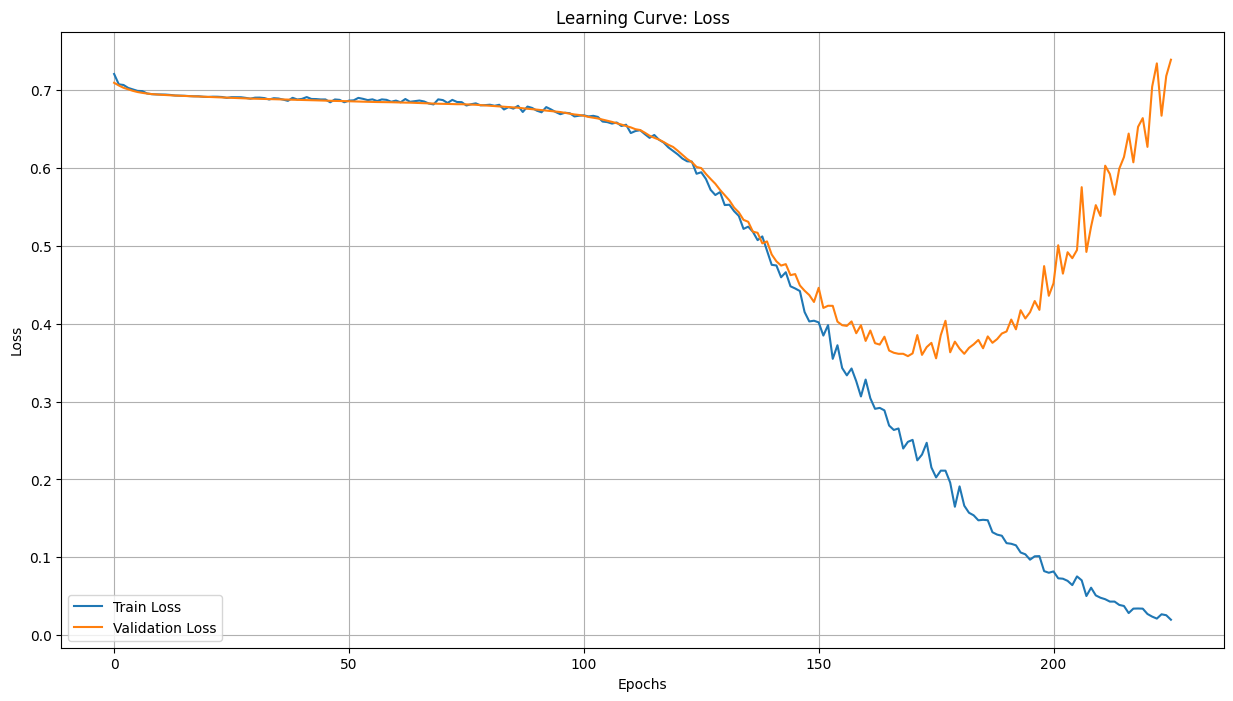

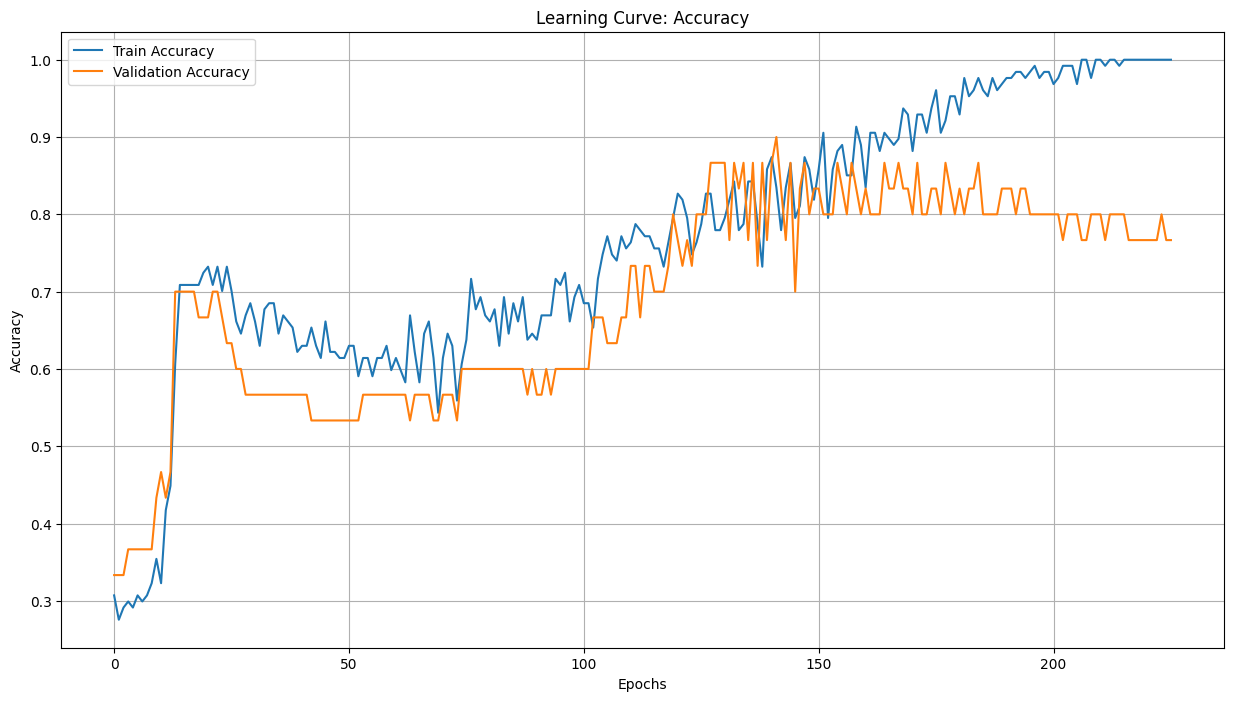

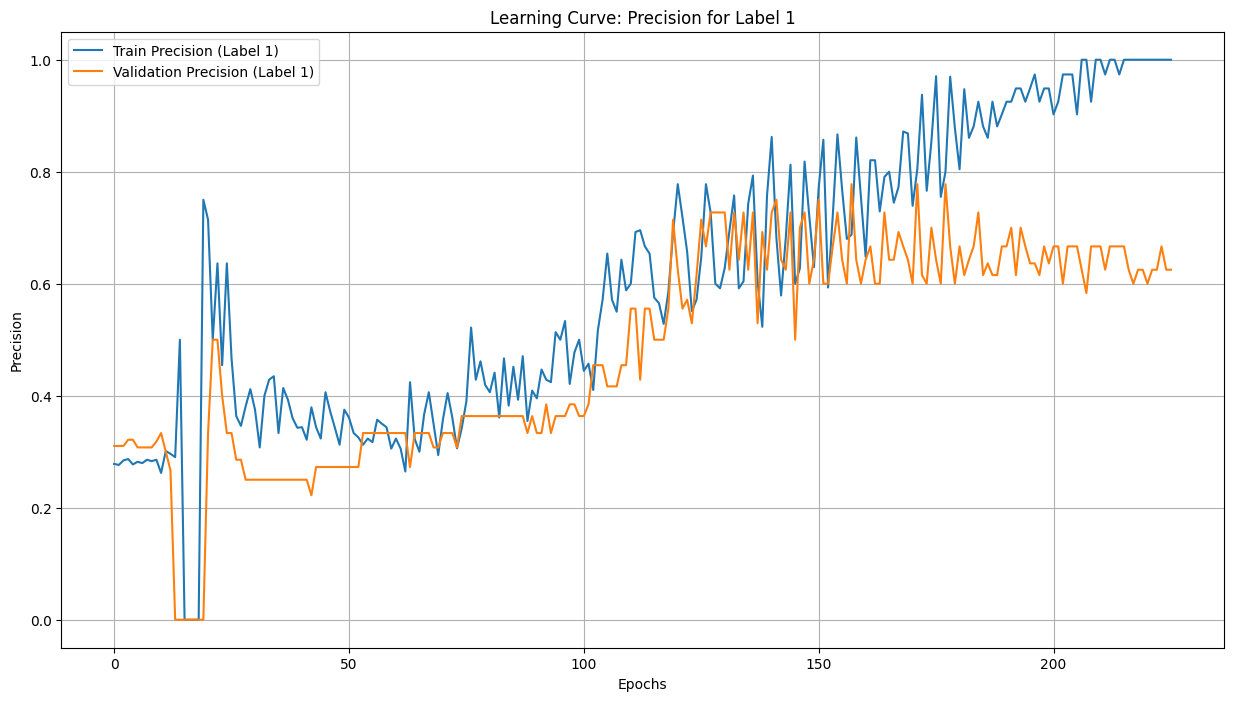

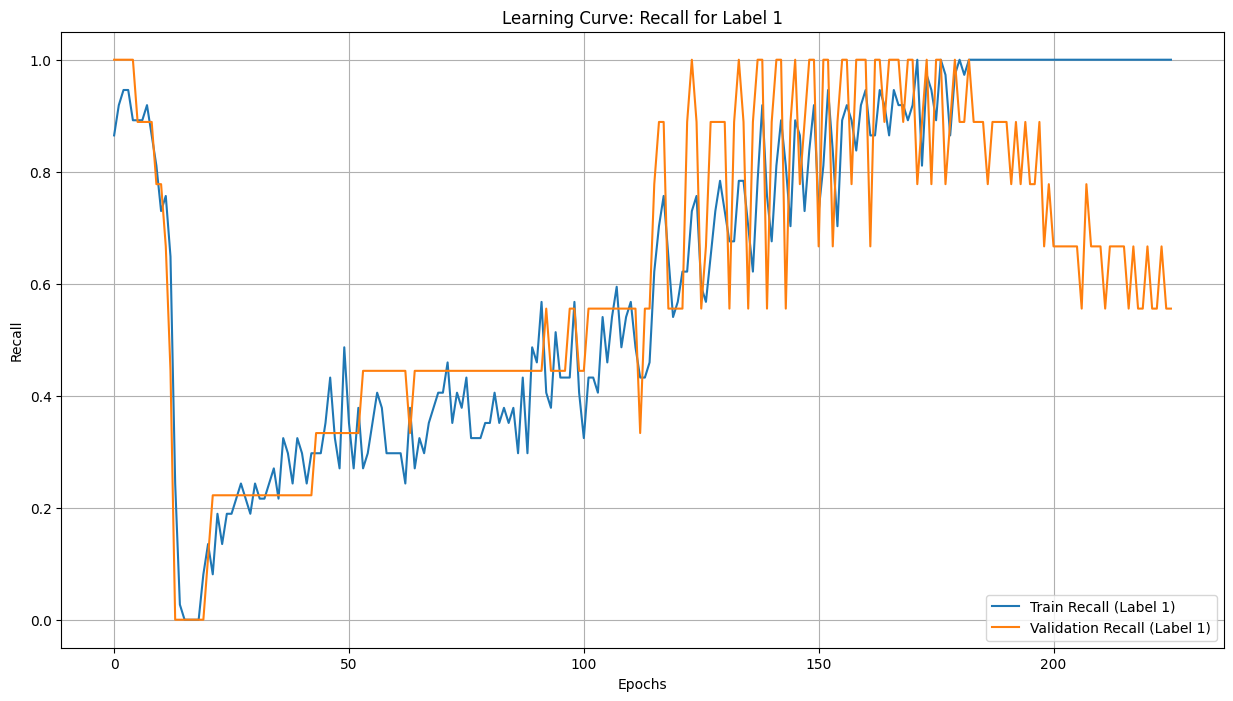

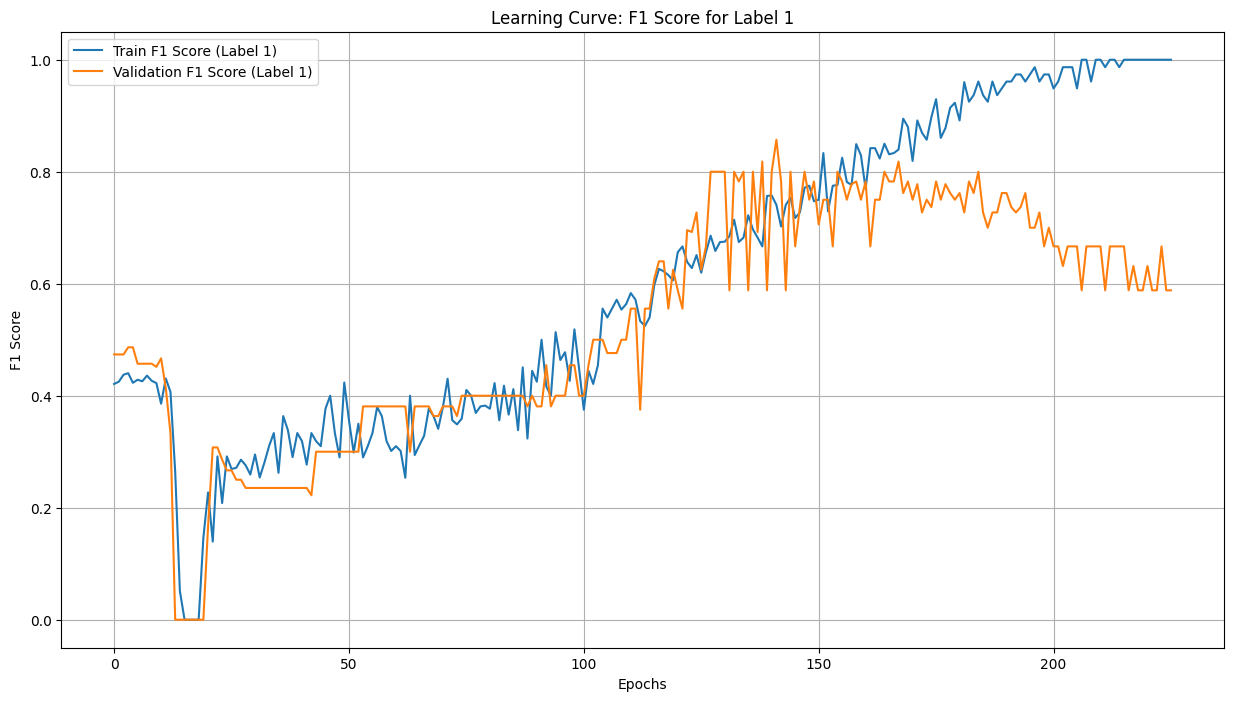

In [75]:
plt.figure(figsize=(15, 8))

#loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Learning Curve: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy
plt.figure(figsize=(15, 8))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Learning Curve: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Precision
plt.figure(figsize=(15, 8))
plt.plot(train_precision_label1, label='Train Precision (Label 1)')
plt.plot(val_precision_label1, label='Validation Precision (Label 1)')
plt.title('Learning Curve: Precision for Label 1')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

# Recall
plt.figure(figsize=(15, 8))
plt.plot(train_recall_label1, label='Train Recall (Label 1)')
plt.plot(val_recall_label1, label='Validation Recall (Label 1)')
plt.title('Learning Curve: Recall for Label 1')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()

# F1 Score
plt.figure(figsize=(15, 8))
plt.plot(train_f1_label1, label='Train F1 Score (Label 1)')
plt.plot(val_f1_label1, label='Validation F1 Score (Label 1)')
plt.title('Learning Curve: F1 Score for Label 1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()


In [76]:
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()

<ipython-input-76-9de1fadd5b5d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_location=device))


MFFNet(
  (text_encoder): MSFastformer(
    (layernorm_in): LayerNorm((200,), eps=1e-12, elementwise_affine=True)
    (layernorm_out): LayerNorm((200,), eps=1e-12, elementwise_affine=True)
    (conv1): Conv1d(200, 200, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(200, 200, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv5): Conv1d(200, 200, kernel_size=(5,), stride=(1,), padding=(2,))
    (fastformer_1): FastformerLayer(
      (attention): FastAttention(
        (self): FastSelfAttention(
          (query): Linear(in_features=200, out_features=200, bias=True)
          (key): Linear(in_features=200, out_features=200, bias=True)
          (value): Linear(in_features=200, out_features=200, bias=True)
          (query_att): Linear(in_features=100, out_features=1, bias=False)
          (m_att): Linear(in_features=100, out_features=1, bias=False)
          (out_proj): Linear(in_features=100, out_features=100, bias=True)
          (merge_heads): Linear(in_features=200, out_featur

In [77]:
all_preds = []
all_labels = []

with torch.no_grad():
    for text_batch, audio_batch, text_mask, audio_mask, label_batch in test_loader:
        # Move to GPU/CPU device
        text_batch = text_batch.to(device)
        audio_batch = audio_batch.to(device)
        text_mask = text_mask.to(device)
        audio_mask = audio_mask.to(device)
        label_batch = label_batch.to(device)

        # Forward pass
        logits = model(text_batch, audio_batch, text_mask, audio_mask)

        # Predicted labels
        _, predicted = torch.max(logits, dim=1)

        # Collect predictions and labels on CPU
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(label_batch.cpu().numpy())

# Convert to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [78]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1']))


              precision    recall  f1-score   support

     Class 0       1.00      0.76      0.86        21
     Class 1       0.64      1.00      0.78         9

    accuracy                           0.83        30
   macro avg       0.82      0.88      0.82        30
weighted avg       0.89      0.83      0.84        30



# Text-only Training

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config(hidden_size=200, intermediate_size=256, num_labels=2,num_attention_heads=2,hidden_dropout_prob=0.2)


In [13]:
model = MFFNet_unimodal(config=config,num_classes=2).to(device)

In [14]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

Total trainable parameters: 2,052,404


In [15]:
n_pos = 0
n_neg = 0

for inputs,a,b,c,labels in train_loader:
    labels = labels.view(-1).float()
    n_pos += labels.sum().item()
    n_neg += (labels.size(0) - labels.sum().item())

print(f"Number of positive samples (N+): {n_pos}")
print(f"Number of negative samples (N-): {n_neg}")

w_pos = n_pos/(n_neg + n_pos)
w_neg = n_neg/(n_neg + n_pos)

print(f"Weight for positive class (W+): {w_pos}")
print(f"Weight for negative class (W-): {w_neg}")

Number of positive samples (N+): 37.0
Number of negative samples (N-): 90.0
Weight for positive class (W+): 0.29133858267716534
Weight for negative class (W-): 0.7086614173228346


In [16]:
weight = torch.tensor([w_pos, w_neg]).to(device)  # shape: [2]

criterion = nn.CrossEntropyLoss(weight=weight)  # For binary classification, this expects labels as integers (0 or 1)
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

In [18]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

num_epochs = 300
patience = 50

train_losses = []
val_losses = []

train_accuracy = []
train_precision_label1 = []
train_recall_label1 = []
train_f1_label1 = []

val_accuracy = []
val_precision_label1 = []
val_recall_label1 = []
val_f1_label1 = []

best_val_loss = float('inf')
no_improve_count = 0

In [19]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for text_batch, audio_batch, text_mask, audio_mask, label_batch in train_loader:
        text_batch = text_batch.to(device)
        text_mask = text_mask.to(device)
        label_batch = label_batch.to(device)

        optimizer.zero_grad()
        logits = model(text_batch)
        loss = criterion(logits, label_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * text_batch.size(0)
        _, predicted = torch.max(logits, 1)
        all_preds.extend(predicted.cpu().tolist())
        all_labels.extend(label_batch.cpu().tolist())

    avg_train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Metrics for training
    train_acc = accuracy_score(all_labels, all_preds)
    train_precision = precision_score(all_labels, all_preds, labels=[1], average='binary', zero_division=0)
    train_recall = recall_score(all_labels, all_preds, labels=[1], average='binary', zero_division=0)
    train_f1 = f1_score(all_labels, all_preds, labels=[1], average='binary', zero_division=0)

    train_accuracy.append(train_acc)
    train_precision_label1.append(train_precision)
    train_recall_label1.append(train_recall)
    train_f1_label1.append(train_f1)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Accuracy: {train_acc:.4f}")

    # Validation step
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for text_val, audio_val, text_mask, audio_mask, label_val in val_loader:
            text_val = text_val.to(device)
            audio_val = audio_val.to(device)
            label_val = label_val.to(device)

            val_logits = model(text_val)
            val_batch_loss = criterion(val_logits, label_val)
            val_loss += val_batch_loss.item() * text_val.size(0)

            _, val_predicted = torch.max(val_logits, 1)
            val_preds.extend(val_predicted.cpu().tolist())
            val_labels.extend(label_val.cpu().tolist())

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    # Metrics for validation
    val_acc = accuracy_score(val_labels, val_preds)
    val_precision = precision_score(val_labels, val_preds, labels=[1], average='binary', zero_division=0)
    val_recall = recall_score(val_labels, val_preds, labels=[1], average='binary', zero_division=0)
    val_f1 = f1_score(val_labels, val_preds, labels=[1], average='binary', zero_division=0)

    val_accuracy.append(val_acc)
    val_precision_label1.append(val_precision)
    val_recall_label1.append(val_recall)
    val_f1_label1.append(val_f1)

    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.4f}")

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve_count = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        no_improve_count += 1
        if no_improve_count >= patience:
            print("No improvement in validation loss for several epochs. Stopping early.")
            break

Epoch [1/300], Train Loss: 0.7211, Accuracy: 0.3228
Epoch [1/300], Val Loss: 0.7027, Accuracy: 0.3333
Epoch [2/300], Train Loss: 0.7018, Accuracy: 0.2677
Epoch [2/300], Val Loss: 0.7003, Accuracy: 0.3333
Epoch [3/300], Train Loss: 0.6996, Accuracy: 0.2913
Epoch [3/300], Val Loss: 0.6981, Accuracy: 0.3667
Epoch [4/300], Train Loss: 0.6979, Accuracy: 0.2913
Epoch [4/300], Val Loss: 0.6967, Accuracy: 0.3667
Epoch [5/300], Train Loss: 0.6969, Accuracy: 0.2913
Epoch [5/300], Val Loss: 0.6954, Accuracy: 0.3667
Epoch [6/300], Train Loss: 0.6959, Accuracy: 0.2913
Epoch [6/300], Val Loss: 0.6946, Accuracy: 0.3333
Epoch [7/300], Train Loss: 0.6938, Accuracy: 0.3622
Epoch [7/300], Val Loss: 0.6941, Accuracy: 0.4000
Epoch [8/300], Train Loss: 0.6945, Accuracy: 0.3937
Epoch [8/300], Val Loss: 0.6937, Accuracy: 0.5000
Epoch [9/300], Train Loss: 0.6933, Accuracy: 0.5433
Epoch [9/300], Val Loss: 0.6934, Accuracy: 0.4333
Epoch [10/300], Train Loss: 0.6933, Accuracy: 0.6772
Epoch [10/300], Val Loss: 0.6

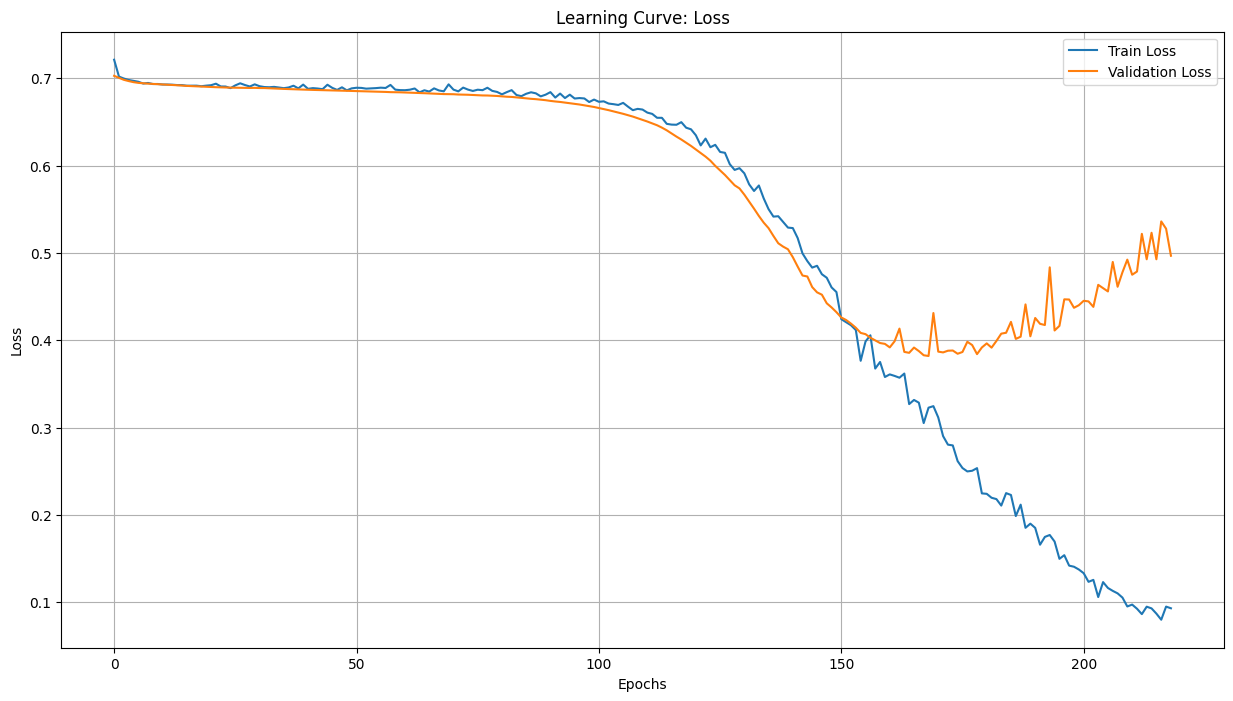

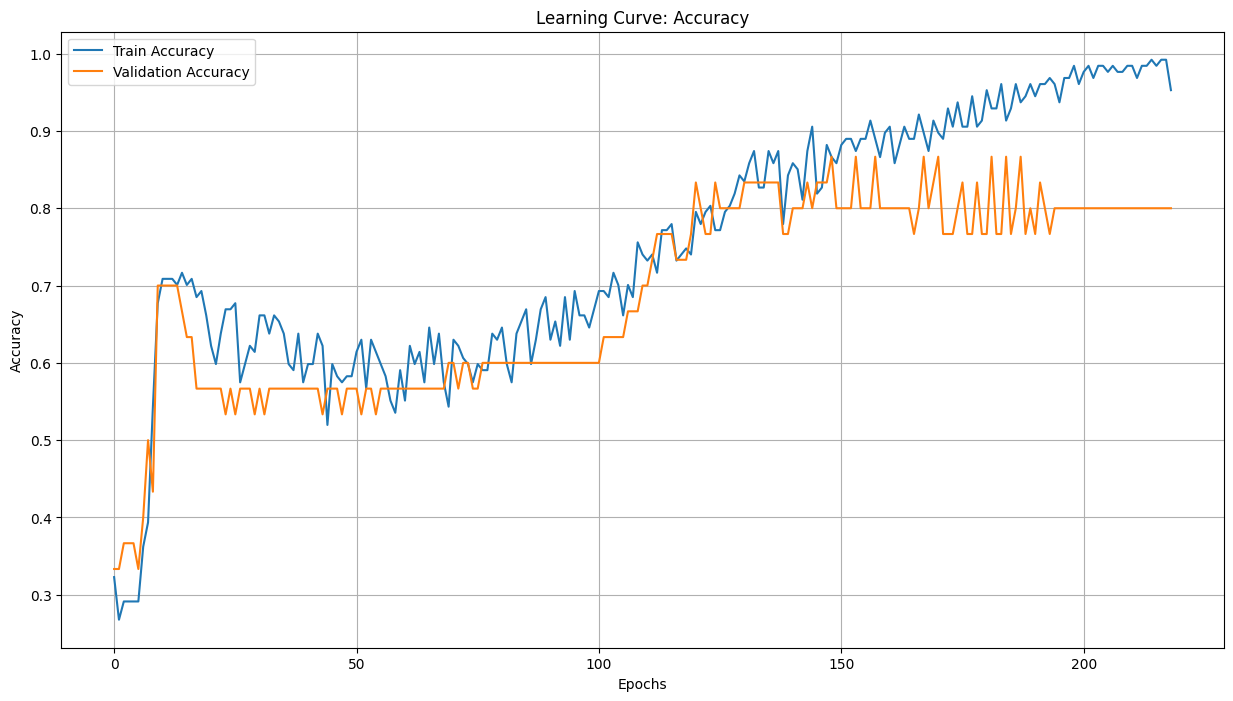

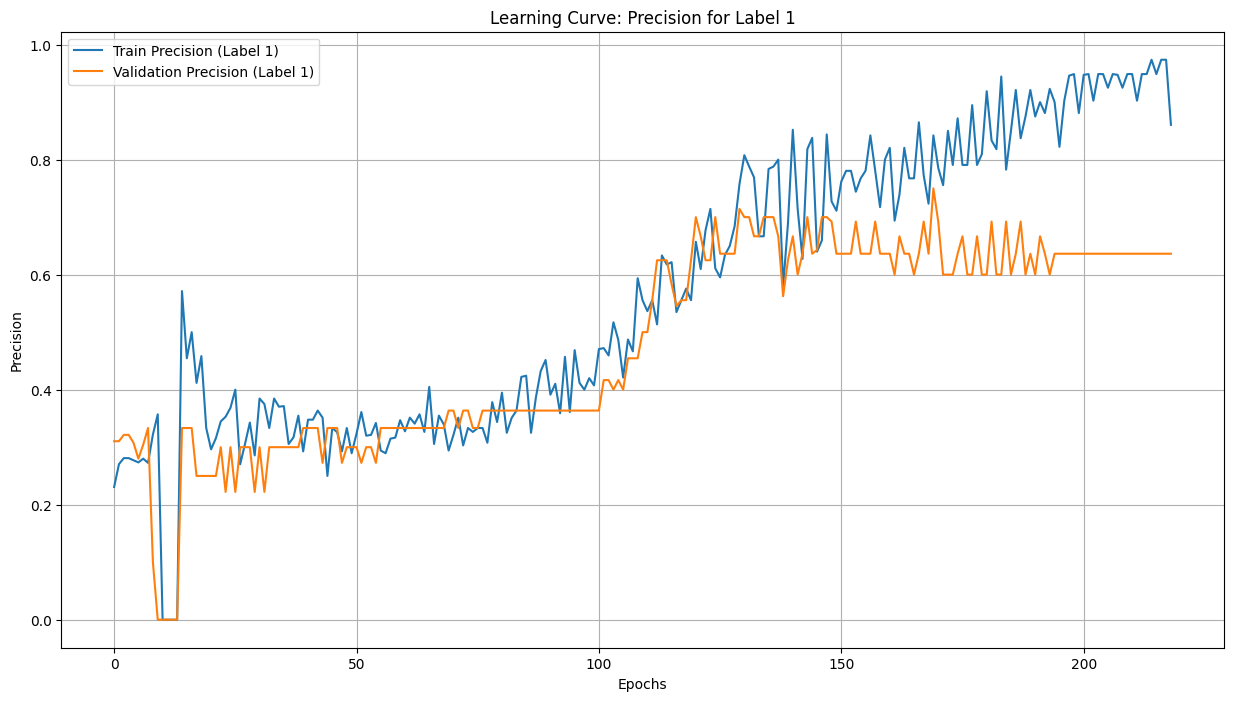

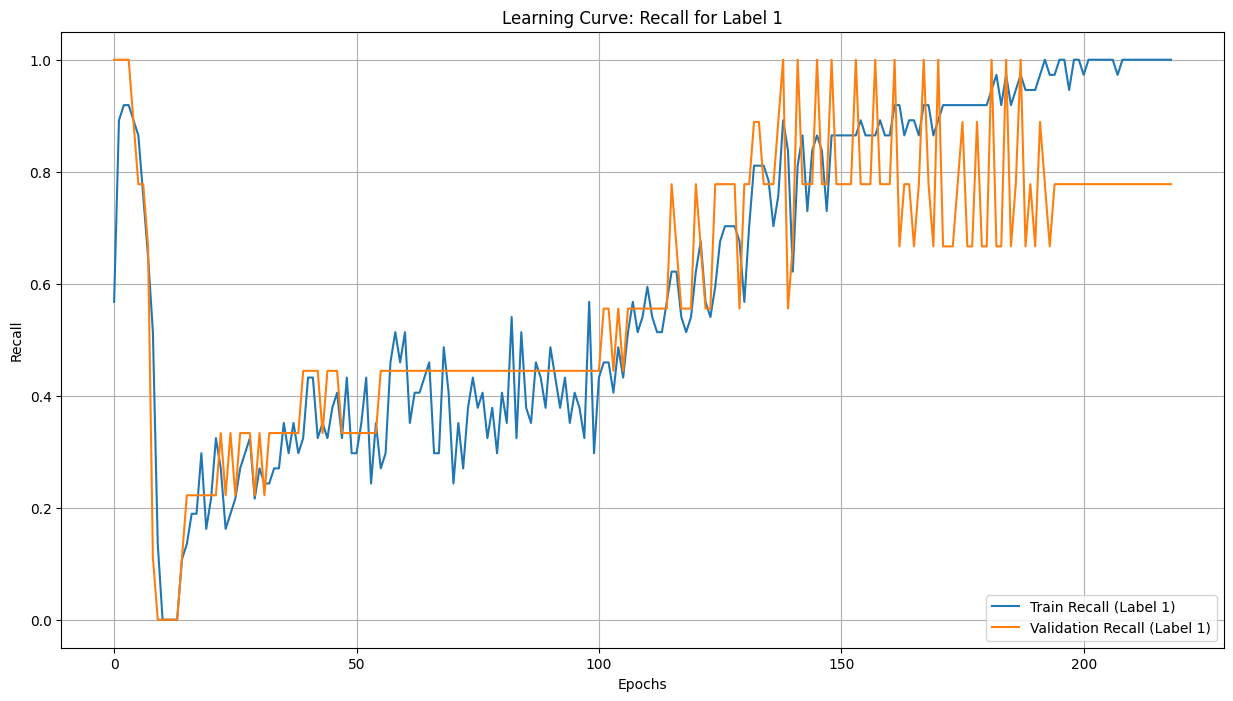

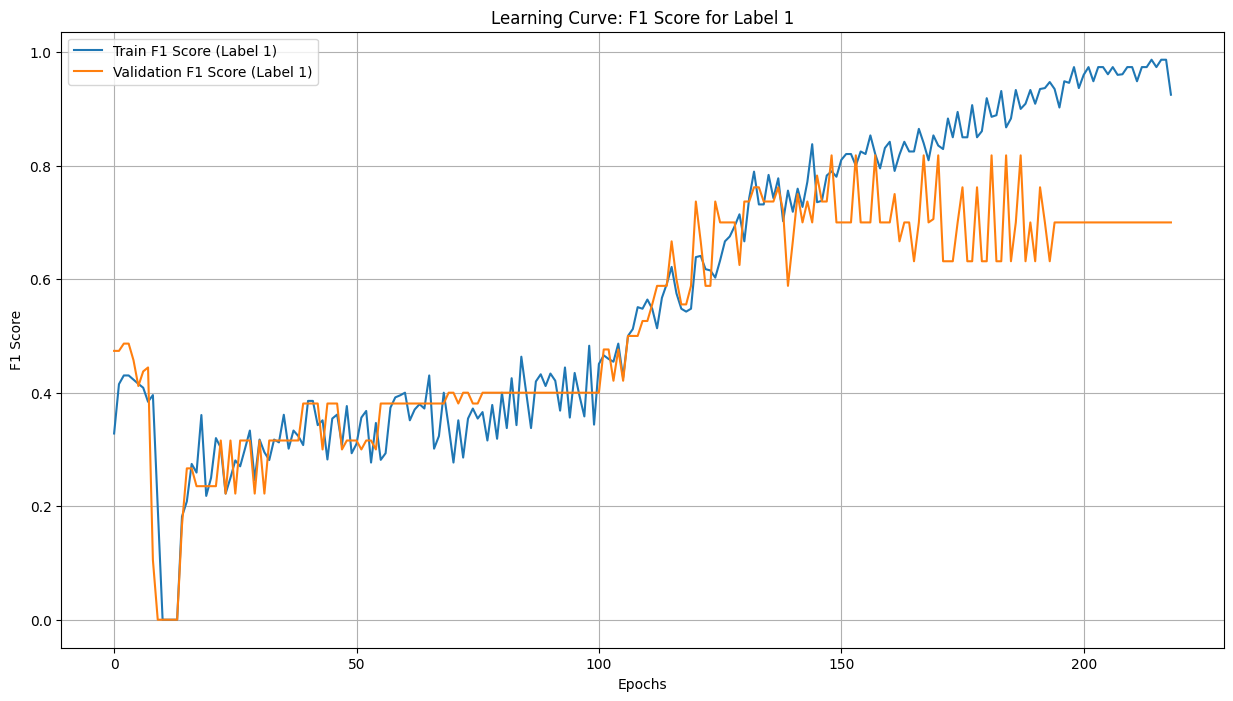

In [20]:
plt.figure(figsize=(15, 8))

#loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Learning Curve: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy
plt.figure(figsize=(15, 8))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Learning Curve: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Precision
plt.figure(figsize=(15, 8))
plt.plot(train_precision_label1, label='Train Precision (Label 1)')
plt.plot(val_precision_label1, label='Validation Precision (Label 1)')
plt.title('Learning Curve: Precision for Label 1')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

# Recall
plt.figure(figsize=(15, 8))
plt.plot(train_recall_label1, label='Train Recall (Label 1)')
plt.plot(val_recall_label1, label='Validation Recall (Label 1)')
plt.title('Learning Curve: Recall for Label 1')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()

# F1 Score
plt.figure(figsize=(15, 8))
plt.plot(train_f1_label1, label='Train F1 Score (Label 1)')
plt.plot(val_f1_label1, label='Validation F1 Score (Label 1)')
plt.title('Learning Curve: F1 Score for Label 1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()

<ipython-input-21-9de1fadd5b5d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_location=device))


MFFNet_unimodal(
  (encoder): MSFastformer(
    (layernorm_in): LayerNorm((200,), eps=1e-12, elementwise_affine=True)
    (layernorm_out): LayerNorm((200,), eps=1e-12, elementwise_affine=True)
    (conv1): Conv1d(200, 200, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(200, 200, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv5): Conv1d(200, 200, kernel_size=(5,), stride=(1,), padding=(2,))
    (fastformer_1): FastformerLayer(
      (attention): FastAttention(
        (self): FastSelfAttention(
          (query): Linear(in_features=200, out_features=200, bias=True)
          (key): Linear(in_features=200, out_features=200, bias=True)
          (value): Linear(in_features=200, out_features=200, bias=True)
          (query_att): Linear(in_features=100, out_features=1, bias=False)
          (m_att): Linear(in_features=100, out_features=1, bias=False)
          (out_proj): Linear(in_features=100, out_features=100, bias=True)
          (merge_heads): Linear(in_features=200, out_fe

In [22]:
all_preds = []
all_labels = []

with torch.no_grad():
    for text_batch, audio_batch, text_mask, audio_mask, label_batch in test_loader:
        # Move to GPU/CPU device
        text_batch = text_batch.to(device)
        audio_batch = audio_batch.to(device)
        text_mask = text_mask.to(device)
        audio_mask = audio_mask.to(device)
        label_batch = label_batch.to(device)

        # Forward pass
        logits = model(text_batch)

        # Predicted labels
        _, predicted = torch.max(logits, dim=1)

        # Collect predictions and labels on CPU
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(label_batch.cpu().numpy())

# Convert to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [23]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1']))


              precision    recall  f1-score   support

     Class 0       0.89      0.81      0.85        21
     Class 1       0.64      0.78      0.70         9

    accuracy                           0.80        30
   macro avg       0.77      0.79      0.77        30
weighted avg       0.82      0.80      0.80        30



# Speech-only

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config(hidden_size=200, intermediate_size=256, num_labels=2,num_attention_heads=2,hidden_dropout_prob=0.2)


In [25]:
model = MFFNet_unimodal(config=config,num_classes=2).to(device)

In [26]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

Total trainable parameters: 2,052,404


In [27]:
n_pos = 0
n_neg = 0

for inputs,a,b,c,labels in train_loader:
    labels = labels.view(-1).float()
    n_pos += labels.sum().item()
    n_neg += (labels.size(0) - labels.sum().item())

print(f"Number of positive samples (N+): {n_pos}")
print(f"Number of negative samples (N-): {n_neg}")

w_pos = n_pos/(n_neg + n_pos)
w_neg = n_neg/(n_neg + n_pos)

print(f"Weight for positive class (W+): {w_pos}")
print(f"Weight for negative class (W-): {w_neg}")

Number of positive samples (N+): 37.0
Number of negative samples (N-): 90.0
Weight for positive class (W+): 0.29133858267716534
Weight for negative class (W-): 0.7086614173228346


In [28]:
weight = torch.tensor([w_pos, w_neg]).to(device)  # shape: [2]

criterion = nn.CrossEntropyLoss(weight=weight)  # For binary classification, this expects labels as integers (0 or 1)
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

In [29]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

num_epochs = 300
patience = 50

train_losses = []
val_losses = []

train_accuracy = []
train_precision_label1 = []
train_recall_label1 = []
train_f1_label1 = []

val_accuracy = []
val_precision_label1 = []
val_recall_label1 = []
val_f1_label1 = []

best_val_loss = float('inf')
no_improve_count = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for text_batch, audio_batch, text_mask, audio_mask, label_batch in train_loader:
        audio_batch = audio_batch.to(device)
        audio_mask = audio_mask.to(device)
        label_batch = label_batch.to(device)

        optimizer.zero_grad()
        logits = model(audio_batch)
        loss = criterion(logits, label_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * text_batch.size(0)
        _, predicted = torch.max(logits, 1)
        all_preds.extend(predicted.cpu().tolist())
        all_labels.extend(label_batch.cpu().tolist())

    avg_train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Metrics for training
    train_acc = accuracy_score(all_labels, all_preds)
    train_precision = precision_score(all_labels, all_preds, labels=[1], average='binary', zero_division=0)
    train_recall = recall_score(all_labels, all_preds, labels=[1], average='binary', zero_division=0)
    train_f1 = f1_score(all_labels, all_preds, labels=[1], average='binary', zero_division=0)

    train_accuracy.append(train_acc)
    train_precision_label1.append(train_precision)
    train_recall_label1.append(train_recall)
    train_f1_label1.append(train_f1)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Accuracy: {train_acc:.4f}")

    # Validation step
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for text_val, audio_val, text_mask, audio_mask, label_val in val_loader:
            text_val = text_val.to(device)
            audio_val = audio_val.to(device)
            label_val = label_val.to(device)

            val_logits = model(audio_val)
            val_batch_loss = criterion(val_logits, label_val)
            val_loss += val_batch_loss.item() * text_val.size(0)

            _, val_predicted = torch.max(val_logits, 1)
            val_preds.extend(val_predicted.cpu().tolist())
            val_labels.extend(label_val.cpu().tolist())

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    # Metrics for validation
    val_acc = accuracy_score(val_labels, val_preds)
    val_precision = precision_score(val_labels, val_preds, labels=[1], average='binary', zero_division=0)
    val_recall = recall_score(val_labels, val_preds, labels=[1], average='binary', zero_division=0)
    val_f1 = f1_score(val_labels, val_preds, labels=[1], average='binary', zero_division=0)

    val_accuracy.append(val_acc)
    val_precision_label1.append(val_precision)
    val_recall_label1.append(val_recall)
    val_f1_label1.append(val_f1)

    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.4f}")

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve_count = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        no_improve_count += 1
        if no_improve_count >= patience:
            print("No improvement in validation loss for several epochs. Stopping early.")
            break

Epoch [1/300], Train Loss: 0.7159, Accuracy: 0.7087
Epoch [1/300], Val Loss: 0.7107, Accuracy: 0.7000
Epoch [2/300], Train Loss: 0.7070, Accuracy: 0.7087
Epoch [2/300], Val Loss: 0.7058, Accuracy: 0.7000
Epoch [3/300], Train Loss: 0.7020, Accuracy: 0.7087
Epoch [3/300], Val Loss: 0.7020, Accuracy: 0.7000
Epoch [4/300], Train Loss: 0.7010, Accuracy: 0.7087
Epoch [4/300], Val Loss: 0.6989, Accuracy: 0.7000
Epoch [5/300], Train Loss: 0.6975, Accuracy: 0.7087
Epoch [5/300], Val Loss: 0.6970, Accuracy: 0.7000
Epoch [6/300], Train Loss: 0.6952, Accuracy: 0.7087
Epoch [6/300], Val Loss: 0.6952, Accuracy: 0.6667
Epoch [7/300], Train Loss: 0.6956, Accuracy: 0.7087
Epoch [7/300], Val Loss: 0.6937, Accuracy: 0.6667
Epoch [8/300], Train Loss: 0.6920, Accuracy: 0.7087
Epoch [8/300], Val Loss: 0.6931, Accuracy: 0.6667
Epoch [9/300], Train Loss: 0.6919, Accuracy: 0.6929
Epoch [9/300], Val Loss: 0.6925, Accuracy: 0.6333
Epoch [10/300], Train Loss: 0.6924, Accuracy: 0.7008
Epoch [10/300], Val Loss: 0.6

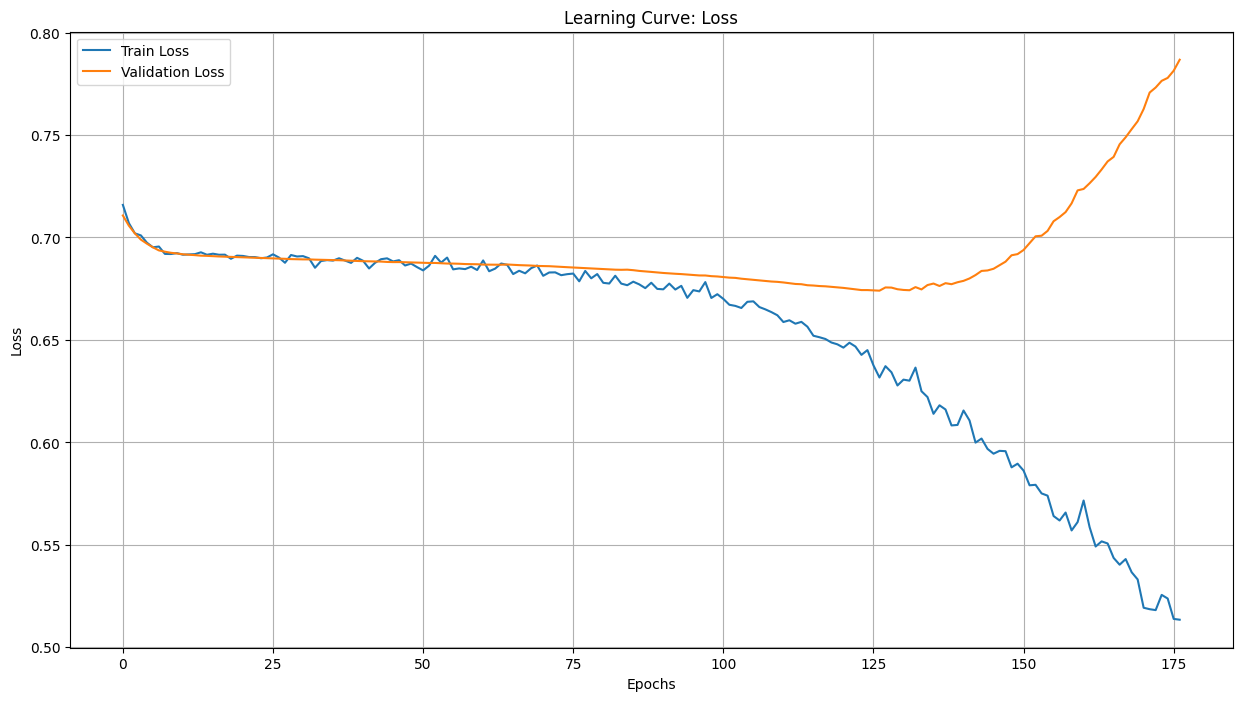

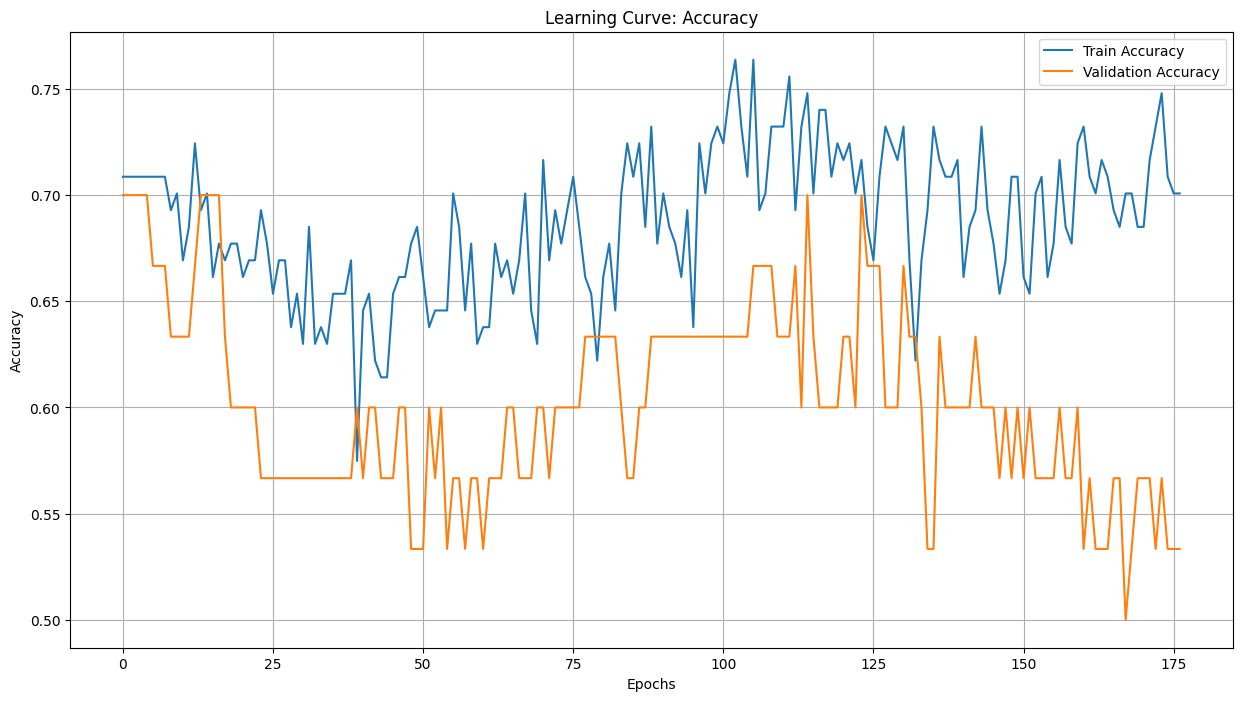

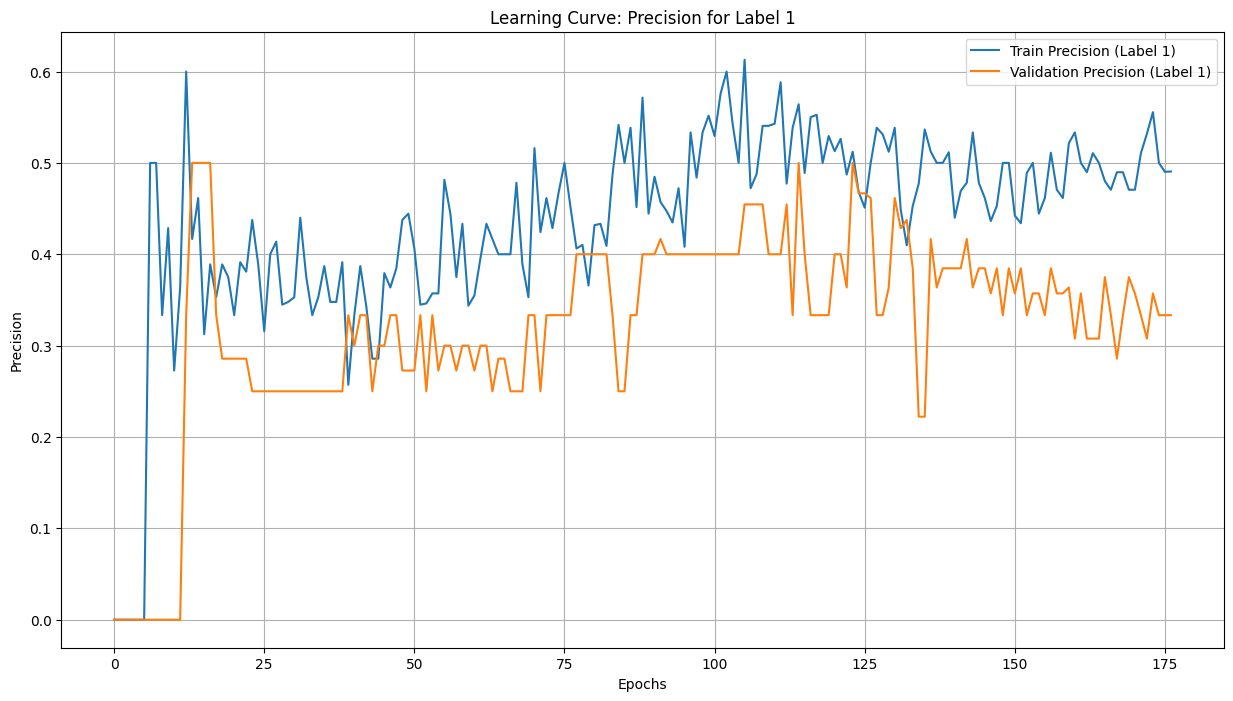

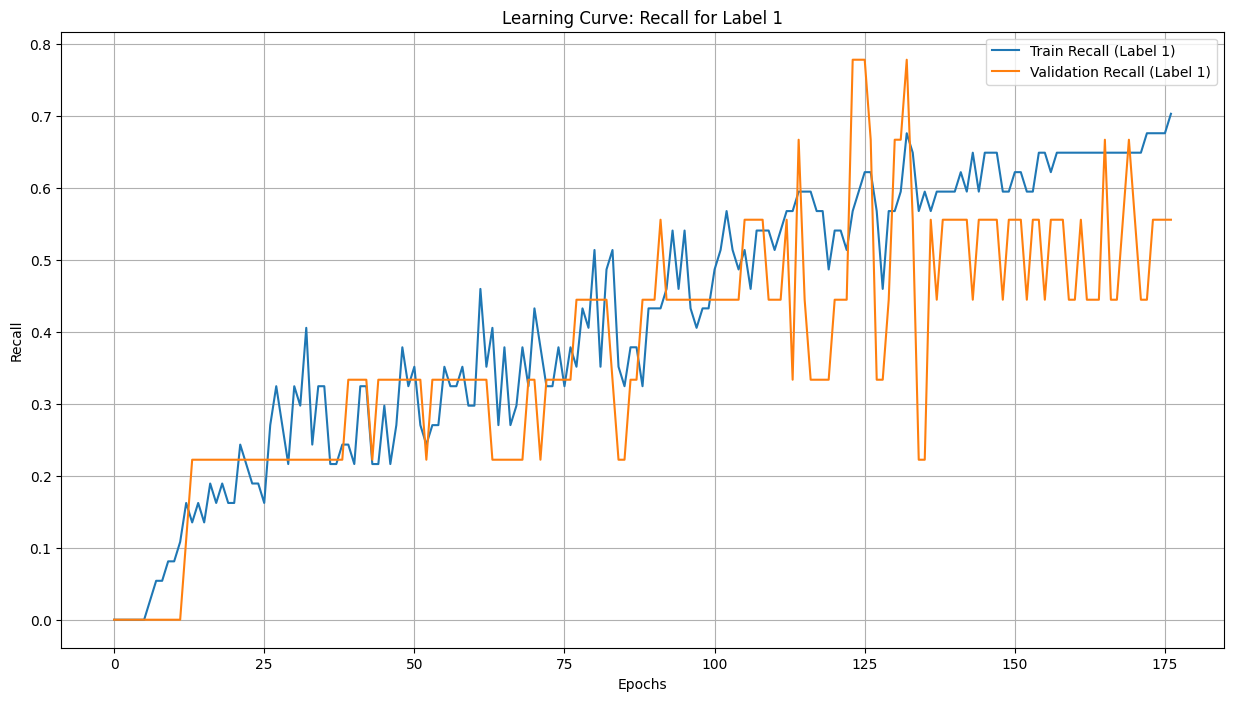

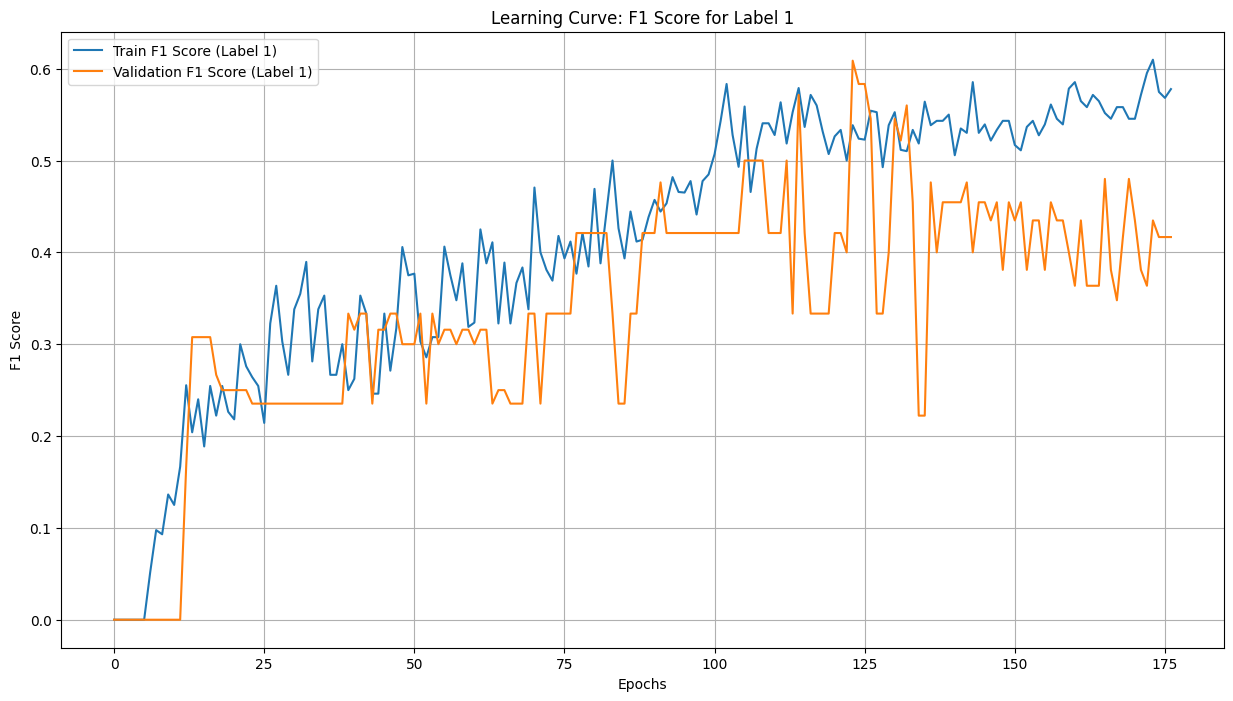

In [30]:
plt.figure(figsize=(15, 8))

#loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Learning Curve: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy
plt.figure(figsize=(15, 8))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Learning Curve: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Precision
plt.figure(figsize=(15, 8))
plt.plot(train_precision_label1, label='Train Precision (Label 1)')
plt.plot(val_precision_label1, label='Validation Precision (Label 1)')
plt.title('Learning Curve: Precision for Label 1')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

# Recall
plt.figure(figsize=(15, 8))
plt.plot(train_recall_label1, label='Train Recall (Label 1)')
plt.plot(val_recall_label1, label='Validation Recall (Label 1)')
plt.title('Learning Curve: Recall for Label 1')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()

# F1 Score
plt.figure(figsize=(15, 8))
plt.plot(train_f1_label1, label='Train F1 Score (Label 1)')
plt.plot(val_f1_label1, label='Validation F1 Score (Label 1)')
plt.title('Learning Curve: F1 Score for Label 1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()

<ipython-input-31-9de1fadd5b5d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_location=device))


MFFNet_unimodal(
  (encoder): MSFastformer(
    (layernorm_in): LayerNorm((200,), eps=1e-12, elementwise_affine=True)
    (layernorm_out): LayerNorm((200,), eps=1e-12, elementwise_affine=True)
    (conv1): Conv1d(200, 200, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(200, 200, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv5): Conv1d(200, 200, kernel_size=(5,), stride=(1,), padding=(2,))
    (fastformer_1): FastformerLayer(
      (attention): FastAttention(
        (self): FastSelfAttention(
          (query): Linear(in_features=200, out_features=200, bias=True)
          (key): Linear(in_features=200, out_features=200, bias=True)
          (value): Linear(in_features=200, out_features=200, bias=True)
          (query_att): Linear(in_features=100, out_features=1, bias=False)
          (m_att): Linear(in_features=100, out_features=1, bias=False)
          (out_proj): Linear(in_features=100, out_features=100, bias=True)
          (merge_heads): Linear(in_features=200, out_fe

In [32]:
all_preds = []
all_labels = []

with torch.no_grad():
    for text_batch, audio_batch, text_mask, audio_mask, label_batch in test_loader:
        # Move to GPU/CPU device
        text_batch = text_batch.to(device)
        audio_batch = audio_batch.to(device)
        text_mask = text_mask.to(device)
        audio_mask = audio_mask.to(device)
        label_batch = label_batch.to(device)

        # Forward pass
        logits = model(audio_batch)

        # Predicted labels
        _, predicted = torch.max(logits, dim=1)

        # Collect predictions and labels on CPU
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(label_batch.cpu().numpy())

# Convert to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

In [33]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1']))


              precision    recall  f1-score   support

     Class 0       0.82      0.67      0.74        21
     Class 1       0.46      0.67      0.55         9

    accuracy                           0.67        30
   macro avg       0.64      0.67      0.64        30
weighted avg       0.71      0.67      0.68        30

